Dataset [link](https://can01.safelinks.protection.outlook.com/?url=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1-6sd6E3cL8uWdNeO4xiXxLbTSYXSTiVr%3Fusp%3Dsharing&data=04%7C01%7Carash.gholami%40queensu.ca%7C92b180b5b67d475fb70e08d87b7f4305%7Cd61ecb3b38b142d582c4efb2838b925c%7C1%7C0%7C637395133804367020%7CUnknown%7CTWFpbGZsb3d8eyJWIjoiMC4wLjAwMDAiLCJQIjoiV2luMzIiLCJBTiI6Ik1haWwiLCJXVCI6Mn0%3D%7C1000&sdata=1ieR3E8llMblC0QMBtx1%2FpHS71RQuCxzdNQLmH0HJVU%3D&reserved=0)

Explanation: There are **49** users' data here. Naming is in the format of Username_ExperimentNumber. Please also note that it is unprocessed raw data, which includes a lot of noise etc. 

Experiment-1: **20** participants are involved in this task and the participants were asked to type **a story** from **a set** of short and simple stories from the American Literature https://americanliterature.com/100-great-short-stories for **four minutes**. The story was chosen randomly by the participants.

Experiment-2: 20 participants are involved in this task and for this data set, all the participants were asked to type the **same text** https://en.wikipedia.org/wiki/The_Adventures_of_Tom_Sawyer for **four minutes**. For each participant, almost the same amount of data is collected as Experiment-1. This dataset is important to be able to measure the quality of the features. The collection of this dataset is quite realistic since in a real case the users could be also asked to type a given text during their CA sessions. 

Experiment-3: The participants are asked to type **10 different pangram sentences**. Pangrams sentences contain** all 26 letters** of the alphabet. This data set is used to test how the **letter distribution** of text affects the result.

Experiment-4: **34** participants are involved in this task and the participants were instructed to imitate someone else's typing pattern by watching the prerecorded video of the other person. For these experiments, one of the participants was recorded on video while typing a short and simple sentence for **15 seconds** from a perspective that the hand motions, smartwatch, keyboard, and the screen could be seen. Although it was not required, the perspective allowed to infer what the victim was typing by watching. This dataset was primarily used to analyze the **attacking scenarios**. It is left to the participant to type the exact same text or imitate the hand movement of the victim.

-----------------------

I realized that you have mostly 4s and 10s as values on column A, but I also found 2s. What does column A represent? 
A represents the sensor type:
 
**10 for the accelerometer
4 for the gyroscope**
2 for the magnetic field sensor

You can find more info about sensors and constant values that are used to define the sensor type in these links:
- https://developer.android.com/guide/topics/sensors/sensors_overview
- https://developer.android.com/reference/android/hardware/Sensor#TYPE_LINEAR_ACCELERATION

Normally, I only collected and used accelerometer and gyroscope sensor data. Magnetometer data should not be in the dataset. If there is, that means it is an **outlier**.
 
Is column B the time stamp, is it recorded at 100HZ?

In an android app, you can set the sampling rate "SENSOR_DELAY_NORMAL, SENSOR_DELAY_UI, SENSOR_DELAY_GAME, or SENSOR_DELAY_FASTEST " 

As far as I remember I used **"SENSOR_DELAY_FASTEST" for all sensors**, but in practice, I had a lot of issues regarding this. They **don't give a constant sampling rate**. Every time I used they were giving different sampling rates. They were giving different sampling rates for two sessions of the same user, for different users, or for different sensors. Therefore, I would recommend using the one in the practice, which you can calculate using the timestamp and the sample count. 

On the paper you said you have recorded both accelerometer and gyro data; but you seem to only have one of them at a time on columns C, D, and F. I am guessing 10 on column A represents accelerometer and 4 gyro, but I could be wrong. 
Also, some rows have more columns, and start with 11 on column A. What do those represent?
Please see the explanation above. 
 

In short, I would really appreciate it if you could let me know information I need to know for working with the data.

Also, as these sensors were giving me a lot of headaches because they are really not stable, I needed to perform a lot of preprocessing. I **cleaned the outliers** before further processing. I also applied some other filtering techniques such as **moving average** to obtain more smooth data. Moreover, I needed to **clean the part the users are not performing typing operation from the beginning and end**, which you can see if you plot the values, i.e., the **user stops meaning no value and then big deviations, where the user takes off the smartwatch**.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

CORES = -1
SEED = 567

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

utility_functions imports setup complete
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case


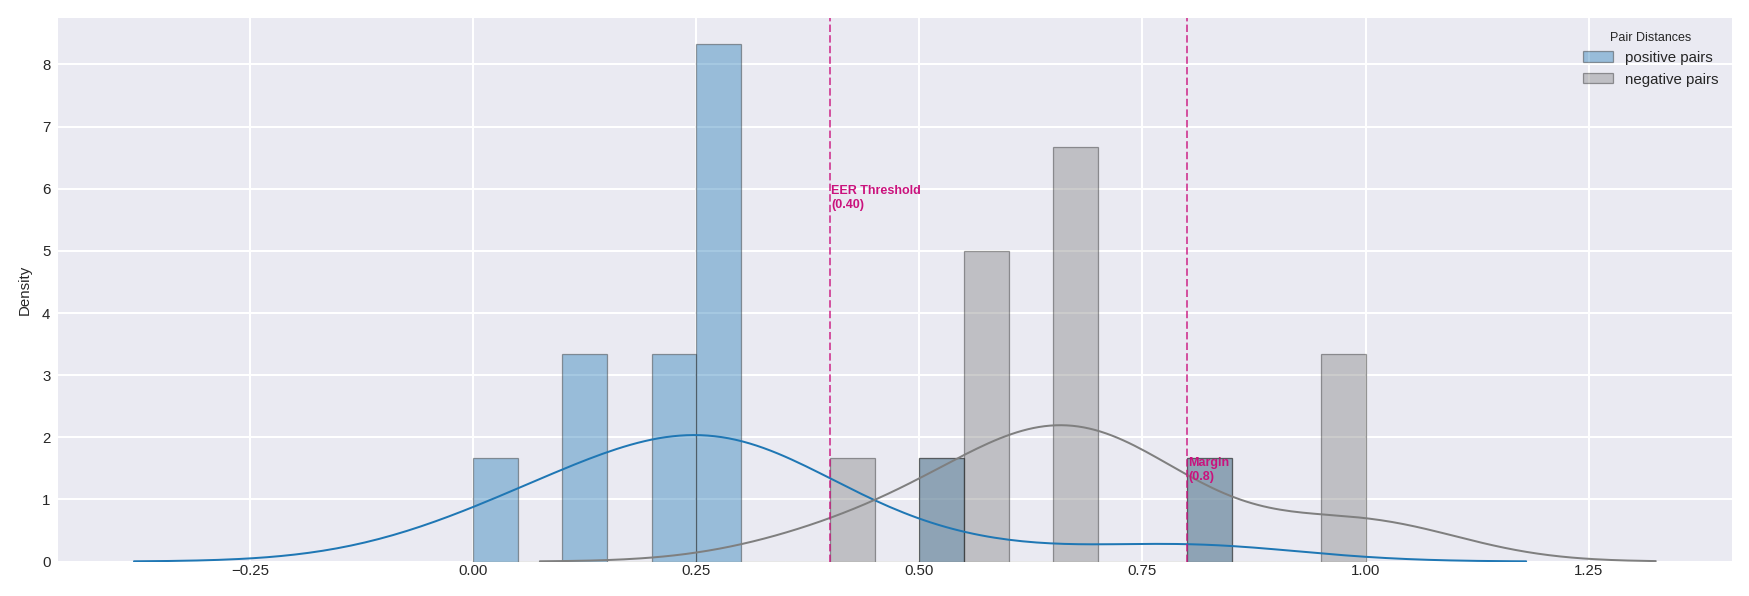

utility functions imported
Numpy Seed was set to: 567
Setup Complete


In [2]:
# !pip install --upgrade pip
# !pip install python-docx
# !pip install antropy

from math import sqrt
from joblib import Parallel, delayed

from sklearn.ensemble import IsolationForest
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dataclasses
import math as math
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
from dataclasses import asdict
from sklearn import svm
from tqdm import tqdm
import warnings
import random
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, accuracy_score, make_scorer, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold # Feature selector
from sklearn.model_selection import KFold

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import iqr
from scipy.stats import median_absolute_deviation
from scipy.stats import mode
from scipy.signal import find_peaks
from scipy.signal import peak_widths
# from scipy.special import entr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
get_new_scaler_dict = {"StandardScaler": StandardScaler, "MinMaxScaler": MinMaxScaler, "Normalizer": Normalizer, 
                       "MaxAbsScaler": MaxAbsScaler, "RobustScaler": RobustScaler, "PowerTransformer": PowerTransformer}
from sklearn.preprocessing import normalize
from sklearn.metrics import auc
# import antropy as ant
import time
# import docx

# Global utitlity functions are in separate notebook
# import utility_functions as uf
%run ./utility-functions.ipynb

np.random.seed(SEED)
print(f"Numpy Seed was set to: {SEED}")

print("Setup Complete")

In [3]:
@dataclasses.dataclass
class ExperimentParameters:
    """Contains all relevant parameters to run an experiment."""

    name: str  # Name of Parameter set. Used as identifier for charts etc.
    frequency: int
    max_subjects: int
    max_test_subjects: int
        
    user_ids: list
    num_sample_points_per_exp: int
    exp_begin_cutoff_idx: int
    exp_end_cutoff_idx: int
        
    
    seconds_per_subject_train: float
    seconds_per_subject_test: float
    window_size: int  # After resampling
    IF_step_width: int  # After resampling
    scaler: str  # StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler, RobustScaler, PowerTransformer
    scaler_scope: str  # {"subject", "session"}
    scaler_global: bool  # fit transform scale on all data (True) or fit on training only (False)
    IF_kernel: str # IF kernel
    IF_nu: float  # Best value found in random search, used for final model
    IF_gamma: float  # Best value found in random search, used for final model
    feature_cols: list  # Columns used as features
    exclude_subjects: list  # Don't load data from those users
        
    # Calculated values
    def __post_init__(self):
        # HDF key of table:
        self.table_name = f"sensors_{self.frequency}hz"

        

# INSTANCES
# ===========================================================

# NAIVE_APPROACH
# -----------------------------------------------------------
NAIVE_MINMAX_IF = ExperimentParameters(
    name="NAIVE-MINMAX_IF",
    frequency=100,
    max_subjects=29,
    max_test_subjects=10,
    user_ids = [1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49],
    num_sample_points_per_exp=21000,
    exp_begin_cutoff_idx=500,
    exp_end_cutoff_idx=-500,
    seconds_per_subject_train=210,
    seconds_per_subject_test=210,    
    window_size=250,
    IF_step_width=250,
    scaler="minmax",
    scaler_scope="subject",
    scaler_global=True,
    IF_kernel="rbf",
    IF_nu=None,
    IF_gamma=None,
    feature_cols=[
        "EMA_x_a",
        "EMA_y_a",
        "EMA_z_a",
        "EMA_x_g",
        "EMA_y_g",
        "EMA_z_g",
    ],
    exclude_subjects=[],
)

# VALID_APPROACH
# -----------------------------------------------------------
VALID_MINMAX_IF = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-MINMAX-IF",
    scaler_global=False,
    IF_nu=0.165,
    IF_gamma=0.039,
)

# NAIVE_ROBUST_APPROACH
# -----------------------------------------------------------
NAIVE_ROBUST_IF = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="NAIVE-ROBUST-IF",
    scaler="robust",
    scaler_global=True,
    IF_nu=0.153,
    IF_gamma=0.091,  # below median, selected by chart
)

# ROBUST_APPROACH (VALID)
# -----------------------------------------------------------
VALID_ROBUST_IF_125 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=125
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)


VALID_ROBUST_IF_250 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=250
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

VALID_ROBUST_IF_500 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=500
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

VALID_ROBUST_IF_750 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=750
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

VALID_ROBUST_IF_1000 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1000
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

VALID_ROBUST_IF_1250 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1250
#     IF_nu=0.037,
#    IF_gamma= 0.001,
)

VALID_ROBUST_IF_1500 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1500
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

VALID_ROBUST_IF_1750 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=1750
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

VALID_ROBUST_IF_2000 = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-ROBUST-IF",
    scaler="RobustScaler",
    scaler_global=False,
    window_size=2000
#     IF_nu=0.037,
#     IF_gamma= 0.001,
)

# NORMALIZER_APPROACH (VALID)
# -----------------------------------------------------------
VALID_NORMALIZER_IF = dataclasses.replace(
    NAIVE_MINMAX_IF,
    name="VALID-NORMALIZER-IF",
    scaler="Normalizer",
    scaler_global=False,
    IF_nu=0.074,
    IF_gamma= 0.029,
)

In [72]:
P = VALID_ROBUST_IF_500
P.IF_step_width = int(P.window_size * .5)
# P = VALID_NORMALIZER_IF

In [5]:
utils_ppp(P)

,Value
name,VALID-ROBUST-IF
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [6]:
[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 28, 29, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49][17]

37

In [7]:
utils_eer_scorer

make_scorer(utils_eer, greater_is_better=False)

# Split Dataset for Valid/Test  
In two splits: one used during hyperparameter optimization, and one used during testing.

The split is done along the subjects: All sessions of a single subject will either be in the validation split or in the testing split, never in both.

They did a 30 60 split.

# Reshaping Raw Features.
We have our own function of windows for this. Do this for both training and testing.

# Extracting time and frequency based features.
Again, we have a function for this. Do this for both training and testing.

# Hyperparameter Optimization 

I do not find any reaqsonable explaination how to use a cross-validation as we are talking about anomaly detection.

I am using the experiment 1 data as train, and experiment 2 data as validation.

# Using SVM in a real-world Scenario with multiple genuine users and intruders
Source: https://datascience.stackexchange.com/questions/23623/what-is-the-best-way-to-classify-data-not-belonging-to-set-of-classes

Stage 1: 
    Use one-class SVM to assign those images that do not belong to the set of predefined classes as the 9-th class.

Stage 2:
    For those images that passes through your filter, let the multi-class SVM assign them to one of the 8 classes.

Loading data:

In [8]:
P.user_ids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 19,
 21,
 22,
 26,
 27,
 28,
 29,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49]

In [9]:
#include 47 later
# user_ids = [9]
df_exps_dict = load_data_frames(P.user_ids, P.exp_begin_cutoff_idx, P.exp_end_cutoff_idx, P.num_sample_points_per_exp)
dfList_exp1, dfList_exp2 = df_exps_dict['dfList_exp1'], df_exps_dict['dfList_exp2']

Loading exp1 data:
1) accel_count: 28388, gyro_count: 31997


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


2) accel_count: 26015, gyro_count: 28954
3) accel_count: 28227, gyro_count: 31814


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


4) accel_count: 24862, gyro_count: 26103
5) accel_count: 24270, gyro_count: 24347


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


6) accel_count: 25012, gyro_count: 25060
7) accel_count: 25301, gyro_count: 25382


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


8) accel_count: 21985, gyro_count: 21658
19) accel_count: 24122, gyro_count: 25050


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


21) accel_count: 24367, gyro_count: 23830
22) accel_count: 29284, gyro_count: 28863


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


26) accel_count: 23148, gyro_count: 24291
27) accel_count: 24299, gyro_count: 23589


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


28) accel_count: 23807, gyro_count: 24523
29) accel_count: 24030, gyro_count: 23475


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


35) accel_count: 24388, gyro_count: 23673
36) accel_count: 24244, gyro_count: 24208


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


37) accel_count: 32022, gyro_count: 31843
38) accel_count: 22138, gyro_count: 22327


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


39) accel_count: 23573, gyro_count: 23459
40) accel_count: 23057, gyro_count: 24296


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


41) accel_count: 24102, gyro_count: 23681
42) accel_count: 24074, gyro_count: 24328


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


43) accel_count: 22631, gyro_count: 23835
44) accel_count: 24474, gyro_count: 23749


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


45) accel_count: 23974, gyro_count: 23229
46) accel_count: 23614, gyro_count: 23827


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


48) accel_count: 22828, gyro_count: 23904
49) accel_count: 24183, gyro_count: 24633
Loading exp2 data:


/tmp/ipykernel_2624/2372085147.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_1.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


1) accel_count: 24049, gyro_count: 26943
2) accel_count: 24472, gyro_count: 27667


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


3) accel_count: 24611, gyro_count: 27000
4) accel_count: 24972, gyro_count: 26798


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


5) accel_count: 23573, gyro_count: 23372
6) accel_count: 23800, gyro_count: 23890


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


7) accel_count: 23347, gyro_count: 24145
8) accel_count: 22964, gyro_count: 22660


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


19) accel_count: 26160, gyro_count: 25846
21) accel_count: 23642, gyro_count: 24444


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


22) accel_count: 23863, gyro_count: 24589
26) accel_count: 23179, gyro_count: 23925


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


27) accel_count: 25121, gyro_count: 25829
28) accel_count: 23133, gyro_count: 24039


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


29) accel_count: 23180, gyro_count: 24314
35) accel_count: 23299, gyro_count: 23854


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


36) accel_count: 25500, gyro_count: 25059
37) accel_count: 25994, gyro_count: 25232


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


38) accel_count: 21168, gyro_count: 21182
39) accel_count: 24214, gyro_count: 23585


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


40) accel_count: 23944, gyro_count: 23170
41) accel_count: 23195, gyro_count: 24111


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


42) accel_count: 26505, gyro_count: 25697
43) accel_count: 22692, gyro_count: 23982


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


44) accel_count: 23002, gyro_count: 23829
45) accel_count: 23978, gyro_count: 23350


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


46) accel_count: 21128, gyro_count: 21848
48) accel_count: 28000, gyro_count: 27205


/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)
/tmp/ipykernel_2624/1994135355.py:9: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv(f'{os.getcwd()}/WACA_dataset/user{i}_2.csv', error_bad_lines = False, header=None, usecols = range(len(names)), dtype = str)


49) accel_count: 23071, gyro_count: 24129


In [10]:
# dfList_exp1[i].shape

In [11]:
i=17
# dfList_exp1[i][['EMA_x_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_y_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_z_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_x_g']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_y_g']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_z_g']].plot(figsize=(30, 6))

# dfList_exp2[i][['EMA_x_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_y_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_z_a']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_x_g']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_y_g']].plot(figsize=(30, 6))
# dfList_exp2[i][['EMA_z_g']].plot(figsize=(30, 6))
# # # exp1 idx 10 has corrupted data frist 50 sec
# # # exp2 idx 12 has some artifacts first 12.5 sec
# # # exp1 idx 17 has some artifacts first 75 sec
# # # exp2 idx 23 has some artifacts last 6.5 sec

# dfList_exp1[i] = dfList_exp1[i][7500:].reset_index(drop=True)

# # dfList_exp1[i][['EMA_x_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_y_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_z_a']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_x_g']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_y_g']].plot(figsize=(30, 6))
# dfList_exp1[i][['EMA_z_g']].plot(figsize=(30, 6))

In [12]:
dfList_exp1[i].shape

(32022, 7)

In [13]:
randomized_data_idx = list(range(len(P.user_ids)))
random.Random(SEED).shuffle(randomized_data_idx)
split_idx = 2 * (len(randomized_data_idx)//3) + 1
train_set = randomized_data_idx[: split_idx]
test_set = randomized_data_idx[split_idx: ]
print(f"train_set: {train_set}\ntest_set: {test_set}")

train_set: [7, 24, 8, 11, 13, 19, 28, 21, 26, 3, 20, 22, 6, 25, 16, 1, 17, 27, 5]
test_set: [0, 12, 14, 9, 18, 23, 2, 15, 10, 4]


In [14]:
# # preparing train data
# # train_set = r
# dfList_exp1_train, dfList_exp2_train = [dfList_exp1[i] for i in train_set], [dfList_exp2[i] for i in train_set]
# print(f"len(dfList_exp1_train): {len(dfList_exp1_train)}")
# print(f"len(dfList_exp2_train): {len(dfList_exp2_train)}")
# XExpTrainDict = MakeRawXExpDic(dfList_exp1_train, dfList_exp2_train, window_size = P.window_size, step=P.IF_step_width, numSamplePoints=P.num_sample_points_per_exp, 
#                                       scale_exp1=False, scale_exp2=True, scaler=P.scaler)

# fitted_scaler_IF_exp2_train_dic = XExpTrainDict["fitted_scaler_exp2_dic"]
# X_exp1_train_dic, X_exp2_train_dic = XExpTrainDict["Raw_X_exp1_dic"], XExpTrainDict["Raw_X_exp2_dic"]

# # preparing test data
# dfList_exp1_test, dfList_exp2_test = [dfList_exp1[i] for i in test_set], [dfList_exp2[i] for i in test_set]
# print(f"len(dfList_exp1_test): {len(dfList_exp1_test)}")
# print(f"len(dfList_exp2_test): {len(dfList_exp2_test)}")
# XExpTestDict = MakeRawXExpDic(dfList_exp1_test, dfList_exp2_test, window_size = P.window_size, step=P.IF_step_width, numSamplePoints=P.num_sample_points_per_exp, 
#                                       scale_exp1=False, scale_exp2=True, scaler=P.scaler)

# fitted_scaler_IF_exp2_test_dic = XExpTestDict["fitted_scaler_exp2_dic"]
# X_exp1_test_dic, X_exp2_test_dic = XExpTestDict["Raw_X_exp1_dic"], XExpTestDict["Raw_X_exp2_dic"]

In [15]:
# X_exp2_train_dic[0].shape
# temporary
import warnings
warnings.filterwarnings("ignore")
def get_raw_windows(window_size, step_width):
    P.window_size = window_size
    P.IF_step_width = step_width
    # preparing train data
    # train_set = r
    dfList_exp1_train, dfList_exp2_train = [dfList_exp1[i] for i in train_set], [dfList_exp2[i] for i in train_set]
    print(f"len(dfList_exp1_train): {len(dfList_exp1_train)}")
    print(f"len(dfList_exp2_train): {len(dfList_exp2_train)}")
    XExpTrainDict = MakeRawXExpDic(dfList_exp1_train, dfList_exp2_train, window_size = P.window_size, step=P.IF_step_width, numSamplePoints=P.num_sample_points_per_exp, 
                                          scale_exp1=False, scale_exp2=True, scaler=P.scaler)

    fitted_scaler_IF_exp2_train_dic = XExpTrainDict["fitted_scaler_exp2_dic"]
    X_exp1_train_dic, X_exp2_train_dic = XExpTrainDict["Raw_X_exp1_dic"], XExpTrainDict["Raw_X_exp2_dic"]

    # preparing test data
    dfList_exp1_test, dfList_exp2_test = [dfList_exp1[i] for i in test_set], [dfList_exp2[i] for i in test_set]
    print(f"len(dfList_exp1_test): {len(dfList_exp1_test)}")
    print(f"len(dfList_exp2_test): {len(dfList_exp2_test)}")
    XExpTestDict = MakeRawXExpDic(dfList_exp1_test, dfList_exp2_test, window_size = P.window_size, step=P.IF_step_width, numSamplePoints=P.num_sample_points_per_exp, 
                                          scale_exp1=False, scale_exp2=True, scaler=P.scaler)

    fitted_scaler_IF_exp2_test_dic = XExpTestDict["fitted_scaler_exp2_dic"]
    X_exp1_test_dic, X_exp2_test_dic = XExpTestDict["Raw_X_exp1_dic"], XExpTestDict["Raw_X_exp2_dic"]
    
    #----
    return X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_IF_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_IF_exp2_test_dic

def extract_features(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_IF_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_IF_exp2_test_dic):
    X_exp_train_dic = MakeWACAXExpDicOwner(X_exp2_train_dic, scaler_clip=True, scaler_type="MinMaxScaler")
    X_exp_train_dic = MakeWACAXExpDicUnknown(X_exp1_train_dic, X_exp_train_dic, fitted_raw_scaler_dict=fitted_scaler_IF_exp2_train_dic)
    X_exp_test_dic = MakeWACAXExpDicOwner(X_exp2_test_dic, scaler_clip=True, scaler_type="MinMaxScaler")
    X_exp_test_dic = MakeWACAXExpDicUnknown(X_exp1_test_dic, X_exp_test_dic, fitted_raw_scaler_dict=fitted_scaler_IF_exp2_test_dic)
    
    return X_exp_train_dic, X_exp_test_dic

In [16]:
# dfList_exp1[0].shape
# a = dfList_exp1[0].copy()
# a = a.drop(columns=["time_stamp"])
# a
# # df.drop(columns=["time_stamp"]).copy()

In [17]:
# print(f"train_set: {train_set}")
# print(f"X_exp1_train_dic: {X_exp1_train_dic.keys()}")
# print(f"X_exp2_train_dic: {X_exp2_train_dic.keys()}")

In [18]:
# print(f"test_set: {test_set}")
# print(f"X_exp1_test_dic: {X_exp1_test_dic.keys()}")
# print(f"X_exp2_test_dic: {X_exp2_test_dic.keys()}")

utility_functions imports setup complete
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case


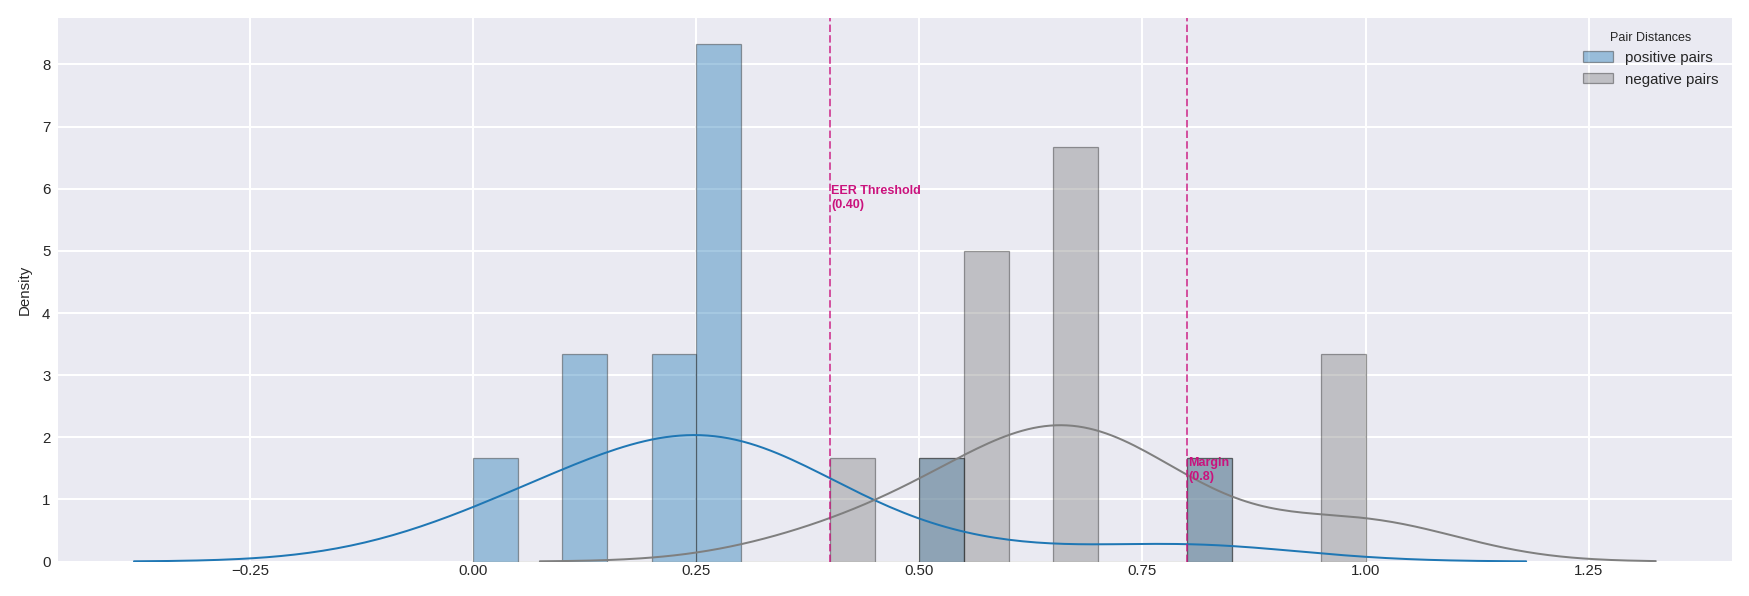

utility functions imported


In [19]:
# print(len(X_exp2_train_dic[0]))
# print(X_exp2_train_dic[0][0].shape)
%run ./utility-functions.ipynb
import warnings
warnings.filterwarnings("ignore")
import timeit



In [20]:
import joblib
joblib.cpu_count()

32

In [21]:
X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_IF_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_IF_exp2_test_dic = \
            get_raw_windows(P.window_size, P.IF_step_width)
# X_exp_train_dic, X_exp_test_dic = \
#     extract_features(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_IF_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_IF_exp2_test_dic)

len(dfList_exp1_train): 19
len(dfList_exp2_train): 19
len(dfList_exp1_test): 10
len(dfList_exp2_test): 10


In [22]:
start = timeit.default_timer()


X_exp_train_dic, X_exp_test_dic = \
    extract_features(X_exp1_train_dic, X_exp2_train_dic, fitted_scaler_IF_exp2_train_dic, X_exp1_test_dic, X_exp2_test_dic, fitted_scaler_IF_exp2_test_dic)


stop = timeit.default_timer()
print('Time: ', stop - start)  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done   2 out of  19 | elapsed:   15.8s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   3 out of  19 | elapsed:   15.9s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   4 out of  19 | elapsed:   15.9s remaining:   59.7s
[Parallel(n_jobs=-1)]: Done   5 out of  19 | elapsed:   16.1s remaining:   45.1s
[Parallel(n_jobs=-1)]: Done   6 out of  19 | elapsed:   16.5s remaining:   35.8s
[Parallel(n_jobs=-1)]: Done   7 out of  19 | elapsed:   16.6s remaining:   28.4s
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:   17.0s remaining:   23.4s
[Parallel(n_jobs=-1)]: Done   9 out of  19 | elapsed:   17.2s remaining:   19.1s
[Parallel(n_jobs=-1)]: Done  10 out of  19 | elapsed:   17.3s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done  11 out of  19 | elapsed:   17.6s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapse

In [23]:
# ( X_exp_train_dic[owner]["profile_windows"] != temp[owner]["profile_windows"]).any()

In [24]:

print('Time: ', stop - start)  
X_exp_train_dic
# X_exp_train_dic[9]
# IF_train_train_WACA_features_dic = MakeWACAXExpDic(X_exp2_train_dic)
# IF_train_valid_WACA_features_dic = MakeWACAXExpDic(X_exp1_train_dic, fitted_scaler_dic=fitted_scaler_IF_exp2_train_dic)
# IF_test_train_WACA_features_dic = MakeWACAXExpDic(X_exp2_test_dic)
# IF_test_test_WACA_features_dic = MakeWACAXExpDic(X_exp1_test_dic, fitted_scaler_dic=fitted_scaler_IF_exp2_test_dic)

Time:  48.22052407823503


{0: {'profile_windows': array([[1.        , 1.        , 0.841263  , ..., 0.54676413, 0.90860453,
          0.94925259],
         [0.46631697, 0.50107812, 0.98771071, ..., 0.1648182 , 0.91807802,
          0.88233504],
         [0.29437031, 0.35101914, 0.95830691, ..., 0.67351772, 0.87798087,
          0.81107603],
         ...,
         [0.06180678, 0.35834818, 0.51474601, ..., 0.39082   , 0.77257338,
          0.882709  ],
         [0.26867882, 0.56960125, 0.26194329, ..., 0.70026938, 0.83300424,
          0.71091735],
         [0.43546688, 0.49556883, 0.55363003, ..., 0.60069661, 0.95463234,
          0.64685727]]),
  'unknown_users_dict': {0: array([[0.37764643, 0.34579465, 0.82071148, ..., 0.88997195, 0.78822576,
           1.        ],
          [0.37860256, 0.44786279, 0.7651379 , ..., 0.96379906, 0.78454977,
           0.73335218],
          [0.46371488, 0.5441181 , 0.58193057, ..., 0.84133219, 0.82478893,
           0.78399423],
          ...,
          [0.19628951, 0.31747747,

In [25]:
# for owner in X_exp_train_dic:
#     if (X_exp_train_dic[owner]["profile_windows"] != temp[owner]["profile_windows"]).any():
#         print("found")
#     for adv in X_exp_train_dic[owner]["unknown_users_dict"]:
#         if (X_exp_train_dic[owner]["profile_windows"][adv] != temp[owner]["profile_windows"][adv]).any():
#             print("found")
            
# print("not found")


In [26]:
# X_exp_train_dic, X_exp_test_dic
# np.ptp(X_exp_train_dic[0]['unknown_users_dict'][0], axis=0)
# X_exp_train_dic[0].keys()

In [27]:
# print(IF_train_train_WACA_features_dic[0].shape)
# print(IF_train_train_WACA_features_dic[0].dtype)

In [28]:
utils_ppp(P)

,Value
name,VALID-ROBUST-IF
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [29]:
# 21000/250

In [30]:
# len(np.linspace(0.0001, 0.3))*len(np.logspace(-3, 3)) * 18

In [31]:
# pd.set_option('display.max_rows', 50)

In [32]:
# # source: https://github.com/dynobo/ContinAuth/blob/master/notebooks/utils.ipynb
# def utils_eer(y_true, y_pred, return_threshold=False):
#     """Calculate the Equal Error Rate.

#     Based on https://stackoverflow.com/a/49555212, https://yangcha.github.io/EER-ROC/
#     and https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object

#     Arguments:
#         y_true {np.array}  -- Actual labels
#         y_pred {np.array}  -- Predicted labels or probability
        
#     Returns:
#         float              -- Equal Error Rate        
#     """
#     # print(y_true)
#     # print(y_pred)
#     # print('---')
#     fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
#     eer = brentq(lambda x: 1.0 - x - interp1d(fpr, tpr)(x), 0.0, 1.0)
#     thresh = interp1d(fpr, thresholds)(eer)  # Calculated threshold, not needed for score
#     if return_threshold:
#         return eer, thresh
#     else:
#         return eer
    
# utils_eer_scorer = make_scorer(utils_eer, greater_is_better=False)

In [86]:
def evaluate_owner_IF_train_valid(owner_idx, X_exp_train_dic, SEED, run, param_dist, CORES):
    run_seed = SEED + run
    train_dic, valid_test_dic = { owner_idx: X_exp_train_dic[owner_idx]["profile_windows"]}, X_exp_train_dic[owner_idx]["unknown_users_dict"] 
                                #IF_train_train_WACA_features_dic, IF_train_valid_WACA_features_dic
    X_vals_owner_idx = utils_create_cv_splits(owner_idx, train_dic, valid_test_dic, seed=run_seed)

    X_test_regular = X_vals_owner_idx['X_test_regular'].copy()
    X_test_anomalous = X_vals_owner_idx['X_test_anomalous'].copy()

#         print(X_vals_owner_idx['cv_splits'])
    cv_splits = X_vals_owner_idx['cv_splits']

#         pca = PCA(n_components = run)
#         X_train = pca.fit_transform(X_train)
#         X_test_regular = pca.transform(X_test_regular)
#         X_test_anomalous = pca.transform(X_test_anomalous)

#         pca_fs.add_user_pca(owner_idx, pca)

    clf = IsolationForest(random_state=run_seed, n_jobs=CORES, verbose=0)

    pipeline = Pipeline([
#                             ('scaler', StandardScaler()), 
                        # ('scaler', get_new_scaler_dict[P.scaler]()), 
#                             ('scaler', Normalizer()),
#                              ('pca', pca), 
#                              ('selector', VarianceThreshold()), 
                         ('model', clf)
                        ])

    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        cv=cv_splits,
        n_iter=120,
        #n_iter=80,
#             n_iter=480,
        n_jobs=CORES,
        refit=False,
        scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
        verbose=0,
        return_train_score=False,
        # iid=False, #invalid arg in sklearn 1.0.2
        error_score="raise",
        random_state=run_seed
    )
#         search = GridSearchCV(
#             pipeline,
#             param_grid=param_dist,
#             cv=cv_splits,
#             n_jobs=CORES,
#             refit=False,
#             scoring={"eer": utils_eer_scorer, "accuracy": "accuracy"},
#             verbose=1,
#             return_train_score=False,
#             iid=False,
#             error_score="raise",
#         )
#         print(X_train.shape)
#         print(X_test_anomalous.shape)


    search.fit(X_vals_owner_idx['X_train'], X_vals_owner_idx['y_train'])
    impostors = [idx for idx in range(len(train_set)) if idx != owner_idx]

    df_report = utils_cv_report(search, owner_idx, impostors)
    df_report["run"] = run
    return df_report

In [34]:
len(train_set)
np.logspace(-3, 3, 6)
# np.arange(0, 10, 10)
np.logspace(1, 1, num=10, dtype=np.int64)
np.linspace(0.001, 0.5, num=6)

array([0.001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5   ])

In [35]:
np.logspace(1, 3, num=10, dtype=np.int64)

array([  10,   16,   27,   46,   77,  129,  215,  359,  599, 1000])

In [47]:
np.logspace(1, 3, num=10, dtype=np.int64)
np.arange(0.1, 1.1, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [88]:
# param_dist = {
#     # "model__gamma": np.logspace(-3, 3), 
#     # "model__nu": np.linspace(0.0001, 0.3),
#     "model__n_estimators": np.logspace(1, 2, num=10, dtype=np.int64), 
#     "model__max_samples": [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0], 
#     "model__contamination": np.linspace(0.001, 0.5, num=6), 
#     "model__max_features": [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0], 
#     "model__bootstrap": [False], 
#     "model__warm_start": [False],
# #     'scaler': [StandardScaler(), MinMaxScaler(),
# #         Normalizer(), MaxAbsScaler()],
# #     "selector__threshold": np.linspace(0, 2, num=1000),

# param_dist
param_dist = {"model__n_estimators": np.logspace(1, 3, num=10, dtype=np.int64), 
              'model__max_samples':  [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0], 
              'model__contamination':[0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1], #[0.001, 0.01, 0.1, .15, 0.2, .25, 0.3, .35, 0.4],#[0.1, .15, 0.2, .25, 0.3, .35, 0.4, .45, .5], 
              'model__max_features': np.arange(0.1, 1.1, 0.1)#[1.0]#[int(.1*i*84) for i in range(1, 11)]#[12, 24, 36, 48, 60, 72, 84]#[5,10,15], 
              # 'model__bootstrap': [True, False], 
              }
# import warnings
# warnings.filterwarnings("ignore")


df_results = None  # Will be filled with randomsearch scores


# Don't need to loop over to find the best PCA.
for run in tqdm(range(3)):
#     df_results[run] = {}
    
    # for owner_idx in tqdm(
    #     range(len(train_set)),
    #     desc="Owner",
    # ):
    #     df_report = evaluate_owner_IF_train_valid(owner_idx, X_exp_train_dic, SEED, run, param_dist, CORES=-1)
    #     df_results = pd.concat([df_results, df_report], sort=False)
    df_reports = Parallel(n_jobs=-1, verbose=100)(delayed(evaluate_owner_IF_train_valid)(owner_idx, X_exp_train_dic, SEED, run, param_dist, CORES=1) for owner_idx in range(len(test_set)))
    # df_reports = Parallel(n_jobs=-1)(delayed(evaluate_owner_IF_train_valid)(owner_idx, X_exp_train_dic, SEED, run, param_dist, CORES=1) for owner_idx in range(len([0])))
    df_results = pd.concat([df_results] + df_reports, sort=False)
        


df_results
#2000 win size
#100%|██████████| 3/3 [01:55<00:00, 38.45s/it] parallel CORES=-1
#100%|██████████| 3/3 [01:53<00:00, 37.92s/it] CORES=-1
#100%|██████████| 3/3 [00:49<00:00, 16.40s/it] parallel CORES=1

#250 win size
#100%|██████████| 3/3 [00:52<00:00, 17.46s/it] CORES=1
#100%|██████████| 3/3 [02:00<00:00, 40.21s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed: 15.7min remaining: 62.8min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 15.7min remaining: 36.7min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed: 15.8min remaining: 23.6min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 15.8min remaining: 15.8min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 15.8min remaining: 10.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 15.8min remaining:  6.8min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed: 15.8min remaining:  4.0min


 33%|███▎      | 1/3 [15:54<31:48, 954.14s/it]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 15.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 15.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed: 12.1min remaining: 48.3min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 12.1min remaining: 28.3min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed: 12.1min remaining: 18.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 12.2min remaining: 12.2min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 12.2min remaining:  8.1min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 12.2min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed: 12.2min remaining:  3.0min


 67%|██████▋   | 2/3 [28:11<13:46, 826.50s/it]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 12.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 12.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed: 12.5min remaining: 50.2min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed: 12.5min remaining: 29.3min
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed: 12.6min remaining: 18.8min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed: 12.6min remaining: 12.6min
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 12.6min remaining:  8.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed: 12.6min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done   8 out of  10 | elapsed: 12.6min remaining:  3.2min


100%|██████████| 3/3 [40:53<00:00, 817.67s/it]

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 12.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 12.7min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__max_samples,param_model__max_features,param_model__contamination,1_test_eer,2_test_eer,...,16_test_accuracy,17_test_accuracy,18_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,0_test_eer,0_test_accuracy
0,0.453447,0.007488,0.121797,0.001021,359,0.6,0.7,0.1,0.087912,0.087912,...,0.951807,0.951807,0.951807,0.947122,0.015101,6,0,0,NaN,NaN
1,0.442412,0.001450,0.116743,0.000640,359,0.8,0.3,0.08,0.107527,0.107527,...,0.939759,0.939759,0.939759,0.939759,0.000000,17,0,0,NaN,NaN
2,1.215314,0.002032,0.318605,0.002730,1000,0.5,0.3,0.01,0.274336,0.467532,...,0.963855,0.909639,0.867470,0.751339,0.129791,93,0,0,NaN,NaN
3,0.035520,0.000208,0.009939,0.000220,27,1.0,0.2,0.04,0.056818,0.204082,...,0.969880,0.963855,0.969880,0.935074,0.055885,30,0,0,NaN,NaN
4,0.712912,0.001332,0.179290,0.000904,599,0.1,0.2,0.03,0.347107,0.392308,...,0.903614,0.921687,0.819277,0.737952,0.119545,96,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.449281,0.001977,0.121763,0.000682,359,0.7,1.0,0.07,0.484472,0.000000,...,0.777108,0.753012,0.584337,0.692102,0.159419,19,9,2,0.201923,0.873494
116,0.268562,0.002384,0.072634,0.000552,215,0.7,0.4,0.06,0.490798,0.000000,...,0.753012,0.765060,0.560241,0.694444,0.165414,18,9,2,0.201923,0.873494
117,0.036122,0.000219,0.010363,0.000126,27,0.3,1.0,0.1,0.471338,0.087912,...,0.692771,0.548193,0.506024,0.634538,0.151190,46,9,2,0.194175,0.879518
118,0.162019,0.001252,0.042704,0.000459,129,0.9,0.1,0.07,0.487654,0.097826,...,0.686747,0.578313,0.530120,0.628514,0.142641,49,9,2,0.209524,0.867470


In [89]:
# len(df_reports)
test_set

[0, 12, 14, 9, 18, 23, 2, 15, 10, 4]

owner: 0 train_idx range: 0, 82
owner: 0 valid_idx range: 83, 165
imposter: 1 valid_idx range: 166, 248
imposter: 2 valid_idx range: 249, 331
imposter: 3 valid_idx range: 332, 414
imposter: 4 valid_idx range: 415, 497
imposter: 5 valid_idx range: 498, 580
imposter: 6 valid_idx range: 581, 663
imposter: 7 valid_idx range: 664, 746
imposter: 8 valid_idx range: 747, 829
imposter: 9 valid_idx range: 830, 912
imposter: 10 valid_idx range: 913, 995
imposter: 11 valid_idx range: 996, 1078
imposter: 12 valid_idx range: 1079, 1161
imposter: 13 valid_idx range: 1162, 1244
imposter: 14 valid_idx range: 1245, 1327
imposter: 15 valid_idx range: 1328, 1410
imposter: 16 valid_idx range: 1411, 1493
imposter: 17 valid_idx range: 1494, 1576
imposter: 18 valid_idx range: 1577, 1659
idx: 0, impostor: 1
idx: 1, impostor: 2
idx: 2, impostor: 3
idx: 3, impostor: 4
idx: 4, impostor: 5
idx: 5, impostor: 6
idx: 6, impostor: 7
idx: 7, impostor: 8
idx: 8, impostor: 9
idx: 9, impostor: 10
idx: 10, impostor: 11
idx

In [50]:
param_dist

{'model__n_estimators': array([  10,   16,   27,   46,   77,  129,  215,  359,  599, 1000]),
 'model__max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
 'model__contamination': [0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
 'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}

owner: 6 train_idx range: 0, 82
owner: 6 valid_idx range: 83, 165
imposter: 0 valid_idx range: 166, 248
imposter: 1 valid_idx range: 249, 331
imposter: 2 valid_idx range: 332, 414
imposter: 3 valid_idx range: 415, 497
imposter: 4 valid_idx range: 498, 580
imposter: 5 valid_idx range: 581, 663
imposter: 7 valid_idx range: 664, 746
imposter: 8 valid_idx range: 747, 829
imposter: 9 valid_idx range: 830, 912
imposter: 10 valid_idx range: 913, 995
imposter: 11 valid_idx range: 996, 1078
imposter: 12 valid_idx range: 1079, 1161
imposter: 13 valid_idx range: 1162, 1244
imposter: 14 valid_idx range: 1245, 1327
imposter: 15 valid_idx range: 1328, 1410
imposter: 16 valid_idx range: 1411, 1493
imposter: 17 valid_idx range: 1494, 1576
imposter: 18 valid_idx range: 1577, 1659
idx: 0, impostor: 0
idx: 1, impostor: 1
idx: 2, impostor: 2
idx: 3, impostor: 3
idx: 4, impostor: 4
idx: 5, impostor: 5
idx: 6, impostor: 7
idx: 7, impostor: 8
idx: 8, impostor: 9
idx: 9, impostor: 10
idx: 10, impostor: 11
idx

In [ ]:
# df_results = Parallel(n_jobs=8)(delayed(evaluate_owner_IF)(owner_idx, SEED, run, param_dist) for owner_idx in tqdm(range(len(train_set)),desc="Owner"))

In [52]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 1.0.2.


In [53]:
pd.set_option('display.max_columns', None)
# df_results[df_results['run']==1 ].groupby('owner').head(40)[6*20:8*20]

In [54]:
# len(df_results[(df_results.rank_test_eer == 1) & (df_results.rank_test_accuracy == 1)])
len(df_results[(df_results.rank_test_eer == 1)])

57

In [55]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# df_results[(df_results.rank_test_eer == 1) & (df_results.rank_test_accuracy == 1)].groupby('owner').head(40)[:269]
df_results[(df_results.rank_test_eer == 1)].groupby('owner').head(232)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__max_samples,param_model__max_features,param_model__contamination,1_test_eer,2_test_eer,3_test_eer,4_test_eer,5_test_eer,6_test_eer,7_test_eer,8_test_eer,9_test_eer,10_test_eer,11_test_eer,12_test_eer,13_test_eer,14_test_eer,15_test_eer,16_test_eer,17_test_eer,18_test_eer,mean_test_eer,std_test_eer,rank_test_eer,1_test_accuracy,2_test_accuracy,3_test_accuracy,4_test_accuracy,5_test_accuracy,6_test_accuracy,7_test_accuracy,8_test_accuracy,9_test_accuracy,10_test_accuracy,11_test_accuracy,12_test_accuracy,13_test_accuracy,14_test_accuracy,15_test_accuracy,16_test_accuracy,17_test_accuracy,18_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,0_test_eer,0_test_accuracy
12,0.035941,0.000147,0.010368,0.000508,27,1.0,84,0.1,0.067416,0.067416,0.067416,0.067416,0.067416,0.067416,0.068966,0.068182,0.068966,0.067416,0.067416,0.068966,0.067416,0.071429,0.067416,0.067416,0.068182,0.067416,0.067982,0.001019,1,0.963855,0.963855,0.963855,0.963855,0.963855,0.963855,0.951807,0.957831,0.951807,0.963855,0.963855,0.951807,0.963855,0.933735,0.963855,0.963855,0.957831,0.963855,0.959505,0.007727,1,0,0,NaN,NaN
12,0.035906,0.000639,0.010295,0.000187,27,1.0,84,0.1,NaN,0.201923,0.515625,0.360825,0.221053,0.279070,0.221053,0.216495,0.380000,0.436364,0.504000,0.201923,0.218750,0.201923,0.203883,0.216495,0.347368,0.380000,0.294926,0.107018,1,NaN,0.873494,0.475904,0.662651,0.819277,0.728916,0.819277,0.831325,0.644578,0.584337,0.493976,0.873494,0.825301,0.873494,0.867470,0.831325,0.674699,0.644578,0.744311,0.130556,1,1,0,0.201923,0.873494
6,1.227387,0.003038,0.330109,0.003258,1000,0.6,48,0.1,0.133333,NaN,0.127660,0.130435,0.275510,0.126316,0.520270,0.136364,0.144578,0.127660,0.133333,0.310680,0.139535,0.236559,0.360360,0.130435,0.126316,0.133333,0.197394,0.107036,1,0.897590,NaN,0.921687,0.909639,0.765060,0.927711,0.463855,0.885542,0.855422,0.921687,0.897590,0.734940,0.873494,0.795181,0.686747,0.909639,0.927711,0.897590,0.836011,0.115257,1,2,0,0.260417,0.777108
53,1.218555,0.002707,0.315039,0.002055,1000,1.0,12,0.1,0.250000,0.056818,NaN,0.309735,0.056818,0.058140,0.056818,0.297297,0.333333,0.344538,0.370968,0.056818,0.056818,0.056818,0.056818,0.056818,0.161290,0.370968,0.167091,0.130762,1,0.813253,0.969880,NaN,0.759036,0.969880,0.957831,0.969880,0.771084,0.734940,0.722892,0.692771,0.969880,0.969880,0.969880,0.969880,0.969880,0.879518,0.692771,0.875167,0.111835,1,3,0,0.056818,0.969880
69,0.096751,0.000492,0.025847,0.000521,77,0.9,12,0.1,0.267442,0.194175,0.432432,NaN,0.250000,0.204082,0.206186,0.491935,0.470588,0.483607,0.461538,0.196078,0.208333,0.194175,0.198020,0.267442,0.315217,0.526316,0.308986,0.124522,1,0.740964,0.879518,0.590361,NaN,0.753012,0.849398,0.843373,0.512048,0.542169,0.524096,0.554217,0.873494,0.837349,0.879518,0.867470,0.740964,0.704819,0.457831,0.723896,0.148245,8,4,0,0.194175,0.879518
53,1.214301,0.002859,0.314889,0.003020,1000,1.0,12,0.1,0.100000,0.097826,0.097826,0.101124,NaN,0.097826,0.097826,0.362069,0.100000,0.097826,0.098901,0.097826,0.098901,0.097826,0.097826,0.229167,0.097826,0.100000,0.120468,0.065775,1,0.933735,0.945783,0.945783,0.927711,NaN,0.945783,0.945783,0.692771,0.933735,0.945783,0.939759,0.945783,0.939759,0.945783,0.945783,0.813253,0.945783,0.933735,0.920683,0.062837,1,5,0,0.097826,0.945783
69,0.095958,0.000631,0.025472,0.000344,77,0.9,12,0.1,0.046512,0.045977,0.047059,0.046512,0.045977,NaN,0.045977,0.122222,0.045977,0.288288,0.254717,0.045977,0.045977,0.045977,0.045977,0.046512,0.487013,0.254717,0.111519,0.122217,1,0.969880,0.975904,0.963855,0.969880,0.975904,NaN,0.975904,0.909639,0.975904,0.783133,0.813253,0.975904,0.975904,0.975904,0.975904,0.969880,0.524096,0.813253,0.916667,0.114427,1,6,0,0.045977,0.975904
61,0.035292,0.000141,0.010231,0.000162,27,0.1,60,0.1,0.333333,0.082353,0.178947,0.123596,0.142857,0.113636,NaN,0.152174,0.417910,0.056818,0.220000,0.178947,0.057471,0.058140,0.113636,0.056818

In [56]:
1*19*3

57

In [57]:
df_results[df_results["owner"] == 14].shape

(240, 54)

In [58]:
# df_results[df_results["owner"] == 14][ df_results["rank_test_eer"] == 1]

In [59]:
display(
    df_results[df_results["rank_test_eer"] == 1]
    .sort_values("mean_test_eer")
    .head(30)
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__max_samples,param_model__max_features,param_model__contamination,1_test_eer,2_test_eer,3_test_eer,4_test_eer,5_test_eer,6_test_eer,7_test_eer,8_test_eer,9_test_eer,10_test_eer,11_test_eer,12_test_eer,13_test_eer,14_test_eer,15_test_eer,16_test_eer,17_test_eer,18_test_eer,mean_test_eer,std_test_eer,rank_test_eer,1_test_accuracy,2_test_accuracy,3_test_accuracy,4_test_accuracy,5_test_accuracy,6_test_accuracy,7_test_accuracy,8_test_accuracy,9_test_accuracy,10_test_accuracy,11_test_accuracy,12_test_accuracy,13_test_accuracy,14_test_accuracy,15_test_accuracy,16_test_accuracy,17_test_accuracy,18_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,0_test_eer,0_test_accuracy
57,0.094760,0.000295,0.024955,0.000272,77,0.4,12,0.1,0.034884,0.047619,0.035714,0.035294,0.035714,0.035714,0.245283,0.034884,0.036145,0.034884,0.035714,0.035294,0.034884,0.111111,0.034884,0.034884,0.035294,0.034884,0.051838,0.050040,1,0.981928,0.957831,0.969880,0.975904,0.969880,0.969880,0.825301,0.981928,0.963855,0.981928,0.969880,0.975904,0.981928,0.921687,0.981928,0.981928,0.975904,0.981928,0.963855,0.036422,1,0,2,NaN,NaN
12,0.035941,0.000147,0.010368,0.000508,27,1.0,84,0.1,0.067416,0.067416,0.067416,0.067416,0.067416,0.067416,0.068966,0.068182,0.068966,0.067416,0.067416,0.068966,0.067416,0.071429,0.067416,0.067416,0.068182,0.067416,0.067982,0.001019,1,0.963855,0.963855,0.963855,0.963855,0.963855,0.963855,0.951807,0.957831,0.951807,0.963855,0.963855,0.951807,0.963855,0.933735,0.963855,0.963855,0.957831,0.963855,0.959505,0.007727,1,0,0,NaN,NaN
53,1.239470,0.008075,0.331064,0.002431,1000,0.9,84,0.1,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.097826,0.000000,1,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.945783,0.000000,1,0,1,NaN,NaN
12,1.206139,0.010410,0.311011,0.003016,1000,0.7,12,0.1,0.046512,0.011905,0.057471,0.023810,0.023810,NaN,0.011905,0.088889,0.088889,0.359375,0.305085,0.011905,0.012048,0.011905,0.011905,0.023810,0.474359,0.344000,0.106638,0.146222,1,0.969880,0.993976,0.963855,0.981928,0.981928,NaN,0.993976,0.945783,0.945783,0.716867,0.777108,0.993976,0.987952,0.993976,0.993976,0.981928,0.548193,0.734940,0.916667,0.126637,1,6,1,0.011905,0.993976
69,0.095958,0.000631,0.025472,0.000344,77,0.9,12,0.1,0.046512,0.045977,0.047059,0.046512,0.045977,NaN,0.045977,0.122222,0.045977,0.288288,0.254717,0.045977,0.045977,0.045977,0.045977,0.046512,0.487013,0.254717,0.111519,0.122217,1,0.969880,0.975904,0.963855,0.969880,0.975904,NaN,0.975904,0.909639,0.975904,0.783133,0.813253,0.975904,0.975904,0.975904,0.975904,0.969880,0.524096,0.813253,0.916667,0.114427,1,6,0,0.045977,0.975904
1,0.262946,0.000798,0.069063,0.000439,215,0.7,24,0.2,0.059524,0.056818,0.170213,0.133333,0.082353,0.056818,0.056818,0.376000,NaN,0.093023,0.338983,0.082353,0.058140,0.056818,0.057471,0.058140,0.056818,0.161290,0.111799,0.094085,1,0.945783,0.969880,0.873494,0.897590,0.927711,0.969880,0.969880,0.686747,NaN,0.921687,0.728916,0.927711,0.957831,0.969880,0.963855,0.957831,0.969880,0.879518,0.915663,0.079868,1,9,2,0.057471,0.963855
68,0.266792,0.001050,0.074419,0.001034,215,0.7,60,0.1,0.144444,0.067416,0.067416,0.153846,NaN,0.067416,0.068182,0.425373,0.069767,0.070588,0.083333,0.067416,0.069767,0.067416,0.068966,0.252427,0.067416,0.180851,0.114414,0.091029,1,0.885542,0.963855,0.963855,0.879518,NaN,0.963855,0.957831,0.620482,0.945783,0.939759,0.921687,0.963855,0.945783,0.963855,0.951807,0.807229,0.963855,0.861446,0.914659,0.083599,1,5,2,0.067416,0.963855
53,1.214301,0.002859,0.314889,0.003020,1000,1.0,12,0.1,0.100000,0.097826,0.097826,0.101124,NaN,0.097826,0.097826,0.362069,0.100000,0.097826,0.098901,0.097826,0.098901,0.097826,0.097826,0.2291

In [60]:
# display(
#     df_results[df_results["rank_test_eer"] == 1][
#         [
#             "mean_fit_time",
#             "param_model__nu",
#             "param_model__gamma",
#             "mean_test_accuracy",
#             "std_test_accuracy",
#             "mean_test_eer",
#             "std_test_eer",
#         ]
#     ].describe()
# )

In [91]:
P.median_n_estimators = None 
P.median_max_samples = None
P.median_contamination = None
P.median_max_features = None


utility_functions imports setup complete
Python 3.9.10
EER: 0.333, Threshold: 0.600 <-- Arbitrary case
EER: 0.000, Threshold: 0.900 <-- Best case
EER: 1.000, Threshold: 0.900 <-- Worse case
EER: 0.400, Threshold: 0.200 <-- Worse case


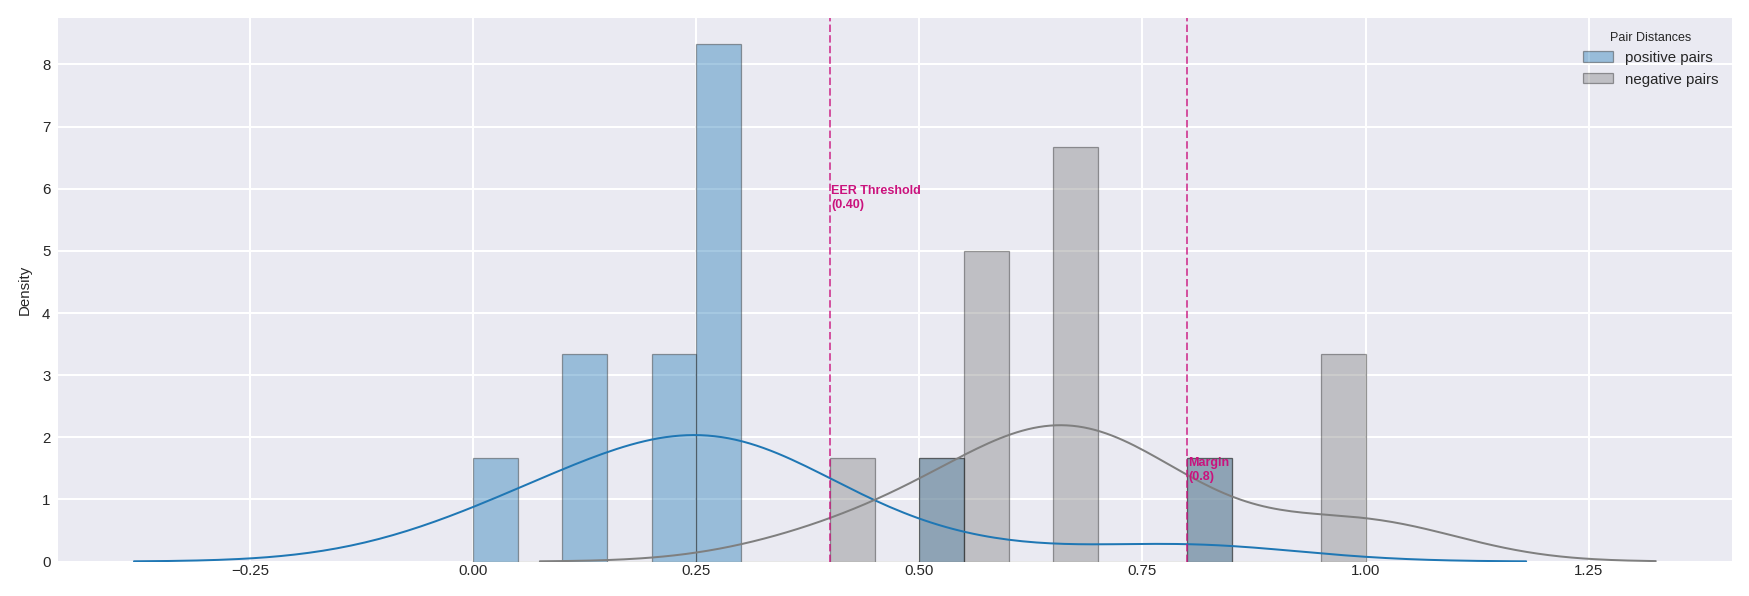

utility functions imported
Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'n_estimators', 'max_samples', 'max_features', 'contamination',
       '1_test_eer', '2_test_eer', '3_test_eer', '4_test_eer', '5_test_eer',
       '6_test_eer', '7_test_eer', '8_test_eer', '9_test_eer', '10_test_eer',
       '11_test_eer', '12_test_eer', '13_test_eer', '14_test_eer',
       '15_test_eer', '16_test_eer', '17_test_eer', '18_test_eer',
       'Mean Test EER', 'std_test_eer', 'rank_test_eer', '1_test_accuracy',
       '2_test_accuracy', '3_test_accuracy', '4_test_accuracy',
       '5_test_accuracy', '6_test_accuracy', '7_test_accuracy',
       '8_test_accuracy', '9_test_accuracy', '10_test_accuracy',
       '11_test_accuracy', '12_test_accuracy', '13_test_accuracy',
       '14_test_accuracy', '15_test_accuracy', '16_test_accuracy',
       '17_test_accuracy', '18_test_accuracy', 'Mean Test Acc.',
       'std_test_accuracy', 'rank_test_accuracy', 'owner', 'run', '0

/tmp/ipykernel_2624/951617972.py:92: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/tmp/ipykernel_2624/951617972.py:92: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


0, −0.28
1, −0.24
2, −0.20
3, −0.16
4, −0.12
5, −0.08
['0.240', '0.200', '0.160', '0.120', '0.080']
0, −0.28
1, −0.24
2, −0.20
3, −0.16
4, −0.12
5, −0.08
['0.240', '0.200', '0.160', '0.120', '0.080']


/tmp/ipykernel_2624/951617972.py:92: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()
/tmp/ipykernel_2624/951617972.py:92: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


0, −0.28
1, −0.24
2, −0.20
3, −0.16
4, −0.12
5, −0.08
['0.240', '0.200', '0.160', '0.120', '0.080']
0, −0.28
1, −0.24
2, −0.20
3, −0.16
4, −0.12
5, −0.08
['0.240', '0.200', '0.160', '0.120', '0.080']


/tmp/ipykernel_2624/951617972.py:92: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


0, −0.28
1, −0.24
2, −0.20
3, −0.16
4, −0.12
5, −0.08
['0.240', '0.200', '0.160', '0.120', '0.080']
77.0 0.8 0.08 0.55


ValueError: Image size of 82513x200 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 421x200 with 1 Axes>

ValueError: Image size of 82513x200 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 421x200 with 1 Axes>

ValueError: Image size of 82513x200 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 421x200 with 1 Axes>

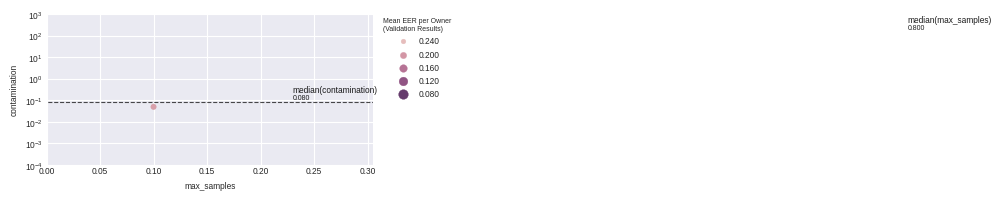

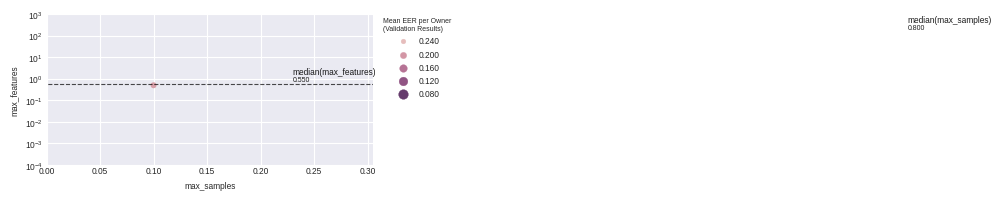

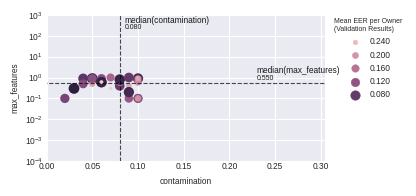

In [115]:
%run ./utility-functions.ipynb
# _, _, _, _, fig = utils_plot_randomsearch_results_IF(df_results, n_top=1)
P.median_n_estimators, P.median_max_samples, P.median_contamination, P.median_max_features, fig = utils_plot_randomsearch_results_IF(df_results[(df_results.rank_test_eer == 1) & (df_results.mean_test_eer < 0.5)], n_top=1)
# plt.savefig(f'WACA-IF-Nu_Gamma_plot-win_size={P.window_size}-step_width={P.IF_step_width}.png', bbox_inches='tight')
print(P.median_n_estimators, P.median_max_samples, P.median_contamination, P.median_max_features)

In [116]:
print(f"median_n_estimators: {P.median_n_estimators},  median_max_samples: {P.median_max_samples},  median_contamination: {P.median_contamination},  median_max_features: {P.median_max_features}")

median_n_estimators: 77.0,  median_max_samples: 0.8,  median_contamination: 0.08,  median_max_features: 0.55


In [98]:
df_results[(df_results.rank_test_eer == 1) & (df_results.mean_test_eer != 0.5)].groupby('owner').head(232)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__max_samples,param_model__max_features,param_model__contamination,1_test_eer,2_test_eer,...,16_test_accuracy,17_test_accuracy,18_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,owner,run,0_test_eer,0_test_accuracy
53,0.035616,0.000168,0.010007,0.000250,27,0.8,0.4,0.1,0.077778,0.077778,...,0.957831,0.957831,0.957831,0.952811,0.008578,1,0,0,NaN,NaN
30,0.263808,0.000642,0.068098,0.000571,215,1.0,0.1,0.1,NaN,0.178218,...,0.885542,0.728916,0.692771,0.779786,0.117057,2,1,0,0.178218,0.891566
71,0.021661,0.000121,0.006318,0.000164,16,0.5,0.2,0.2,0.155556,NaN,...,0.861446,0.915663,0.867470,0.853748,0.063143,1,2,0,0.178571,0.825301
57,0.443437,0.002281,0.118396,0.000939,359,1.0,0.4,0.1,0.300885,0.045977,...,0.975904,0.891566,0.801205,0.893240,0.096632,1,3,0,0.045977,0.975904
30,0.265926,0.000534,0.068962,0.000565,215,1.0,0.1,0.1,0.305882,0.224299,...,0.819277,0.753012,0.578313,0.737282,0.131907,1,4,0,0.224299,0.855422
8,1.250851,0.007144,0.342418,0.002105,1000,1.0,0.7,0.1,0.120879,0.117021,...,0.783133,0.933735,0.849398,0.888554,0.085105,1,5,0,0.117021,0.933735
57,0.443803,0.000827,0.119217,0.001178,359,1.0,0.4,0.1,0.057471,0.056818,...,0.957831,0.530120,0.939759,0.931392,0.101622,1,6,0,0.056818,0.969880
15,0.035753,0.000182,0.010502,0.000152,27,0.4,0.7,0.1,0.323810,0.126316,...,0.915663,0.915663,0.879518,0.858434,0.083647,2,7,0,0.174419,0.837349
72,0.160724,0.001027,0.043010,0.000539,129,0.5,0.4,0.2,0.170000,0.170000,...,0.879518,0.897590,0.897590,0.867470,0.055721,1,8,0,0.170000,0.897590
37,0.262128,0.000740,0.066888,0.000369,215,0.6,0.1,0.2,0.102273,0.097826,...,0.915663,0.945783,0.861446,0.885877,0.077185,1,9,0,0.100000,0.933735


In [70]:
# P.IF_nu, P.IF_gamma = 0.098, 0.002
# NORMALIZER-SCALER
# P.IF_nu, P.IF_gamma = 0.074, 0.029
# ROBUST-SCALER-250
# P.IF_nu, P.IF_gamma = 0.037, 0.001
# ROBUST-SCALER-1000-1000
# P.IF_nu, P.IF_gamma = 0.141, 0.494
# ROBUST-SCALER-1000-250
# P.IF_nu, P.IF_gamma = 0.147, 0.655
# P.IF_nu, P.IF_gamma = 0.098, 0.003
# P.IF_nu, P.IF_gamma = 0.104, 0.004

In [71]:
utils_ppp(P)

,Value
name,VALID-ROBUST-IF
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [72]:
# utils_plot_acc_eer_dist(df_plot, "Test Accuracy")

In [73]:
# utils_plot_acc_eer_dist(df_results, "Test EER")

In [74]:
# from sklearn.model_selection import KFold 
# temp_split = KFold(n_splits=5, shuffle=False, random_state=None)
# temp_split.get_n_splits(X_exp2_test_dic[0])

In [75]:
# for train_index, test_index in temp_split.split(X_exp2_test_dic[0]):
#     print(train_index, test_index)
#     print('---')

In [127]:
# X_vals_owner_idx['X_train'][162: 243].sum()

In [128]:
# X_vals_owner_idx['X_train'][243: 324].sum()

In [129]:
# train_test_cv_splits[1]

In [36]:
# test_set

        
#         run_seed = SEED + run
#         train_dic, valid_test_dic = { owner_idx: X_exp_test_dic[owner_idx]["profile_windows"]}, X_exp_test_dic[owner_idx]["unknown_users_dict"] 
#         X_vals_owner_idx = utils_create_cv_splits(owner_idx, train_dic, valid_test_dic, seed=run_seed)
        
#         X_test_regular = X_vals_owner_idx['X_test_regular']
#         X_test_anomalous = X_vals_owner_idx['X_test_anomalous']

#         train_test_cv_splits = X_vals_owner_idx['cv_splits']
        
        
#         pca = PCA(n_components = run+3)
# #         X_train = pca.fit_transform(X_train)
# #         X_test_regular = pca.transform(X_test_regular)
# #         X_test_anomalous = pca.transform(X_test_anomalous)
        
#         clf = IsolationForest(n_estimators = np.int64(P.median_n_estimators), 
#                           max_samples = P.median_max_samples, 
#                           contamination = P.median_contamination, 
#                           max_features = np.int64(P.median_max_features), 
#                           random_state=run_seed, n_jobs=CORES, verbose=1)
#         pipeline = Pipeline([
#                             # ('scaler', get_new_scaler_dict[P.scaler]()), 
# #                             ('scaler2', Normalizer()),#best result
# #                              ('pca', pca), 
# #                              ('selector', VarianceThreshold()), 
#                             ('model', clf)
#                             ])
        
#         scores = cross_validate(
#             pipeline,
#             X_vals_owner_idx['X_train'],
#             X_vals_owner_idx['y_train'],
#             cv=train_test_cv_splits,
#             scoring={
#                 "eer": utils_eer_scorer,
#                 "accuracy": "accuracy",
#                 "precision": "precision",
#                 "recall": "recall",
#             },
#             n_jobs=CORES,
#             verbose=1,
#             return_train_score=True,error_score='raise'
#         )
# #         print(df_score["test_eer"])
#         df_score = pd.DataFrame(scores)
#         df_score["owner"] = test_set[owner_idx]
#         df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
#         df_score["test_eer"] = df_score["test_eer"].abs()
#         test_df_results = pd.concat([test_df_results, df_score], axis=0)

IndentationError: unexpected indent (4180915578.py, line 4)

In [78]:
def evaluate_owner_IF_train_test(owner_idx, X_exp_test_dic, SEED, run, optimal_params, CORES):
    run_seed = SEED + run
    train_dic, valid_test_dic = { owner_idx: X_exp_test_dic[owner_idx]["profile_windows"]}, X_exp_test_dic[owner_idx]["unknown_users_dict"] 
                                #IF_train_train_WACA_features_dic, IF_train_valid_WACA_features_dic
    X_vals_owner_idx = utils_create_cv_splits(owner_idx, train_dic, valid_test_dic, seed=run_seed)

    X_test_regular = X_vals_owner_idx['X_test_regular'].copy()
    X_test_anomalous = X_vals_owner_idx['X_test_anomalous'].copy()

#         print(X_vals_owner_idx['cv_splits'])
    train_test_cv_splits = X_vals_owner_idx['cv_splits']
    # print(X_vals_owner_idx['y_train'])
#         pca = PCA(n_components = run+3)
#         X_train = pca.fit_transform(X_train)
#         X_test_regular = pca.transform(X_test_regular)
#         X_test_anomalous = pca.transform(X_test_anomalous)

#         pca_fs.add_user_pca(owner_idx, pca)

    clf = IsolationForest(n_estimators = np.int64(optimal_params.median_n_estimators), 
                          max_samples = optimal_params.median_max_samples, 
                          contamination = optimal_params.median_contamination, 
                          max_features = np.int64(optimal_params.median_max_features), 
                          random_state=run_seed, n_jobs=CORES, verbose=1)
    pipeline = Pipeline([
                        # ('scaler', get_new_scaler_dict[P.scaler]()), 
#                             ('scaler2', Normalizer()),#best result
#                              ('pca', pca), 
#                              ('selector', VarianceThreshold()), 
                        ('model', clf)
                        ])

    
    scores = cross_validate(
        pipeline,
        X_vals_owner_idx['X_train'],
        X_vals_owner_idx['y_train'],
        cv=train_test_cv_splits,
        scoring={
            "eer": utils_eer_scorer,
            "accuracy": "accuracy",
            "precision": "precision",
            "recall": "recall",
        },
        n_jobs=CORES,
        verbose=1,
        return_train_score=True,error_score='raise'
    )

    # print(df_score["test_eer"])
    df_score = pd.DataFrame(scores)
    df_score["owner"] = test_set[owner_idx]
    df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
    df_score["test_eer"] = df_score["test_eer"].abs()
    # df_score["run"] = run
    
    print(df_score)
    return df_score
        
    # df_report["run"] = run shalll i go this route
    
    
 


In [46]:
# evaluate_owner_IF_train_test(2, X_exp_test_dic, SEED, run, param_dist, CORES=1)

In [94]:
test_set
print(f"median_n_estimators: {P.median_n_estimators},  median_max_samples: {P.median_max_samples},  median_contamination: {P.median_contamination},  median_max_features: {P.median_max_features}")

median_n_estimators: 77.0,  median_max_samples: 0.8,  median_contamination: 0.08,  median_max_features: 0.55


In [38]:
# param_dist
# P.median_n_estimators = 46 
# P.median_max_samples = 0.6
# P.median_contamination = 0.1
# P.median_max_features = 84

In [73]:
1/85

0.011764705882352941

In [110]:
# df_score
# P.median_n_estimators = 77.0
# P.median_max_samples = 0.6
# P.median_contamination = 0.1
# P.median_max_features = 60.0

# P.median_n_estimators = 77
# P.median_max_samples = 0.6
# P.median_contamination = 0.011
# P.median_max_features = 60


# P.median_n_estimators = 129.0  
# P.median_max_samples = 0.8
# P.median_contamination = 0.1
# P.median_max_features = int(0.4 * 84)

# P.median_n_estimators = 129.0
# P.median_max_samples = 0.8
# P.median_contamination = 0.1
# P.median_max_features = int(0.5*84)

#P.median_n_estimators = 1000.0 
#P.median_max_samples = 0.8
#P.median_contamination = 0.001
#P.median_max_features = int(84)

P.median_n_estimators = 129.0
P.median_max_samples = .8
P.median_contamination = 0.05
P.median_max_features = int(0.55*84)

P.median_n_estimators = 77.0
P.median_max_samples = 0.8
P.median_contamination = 0.08
P.median_max_features = int(0.55*84)

P.median_n_estimators = 77.0
P.median_max_samples = 1.0
P.median_contamination = 0.08
P.median_max_features = 84

In [111]:
test_set
# X_exp_test_dic

[0, 12, 14, 9, 18, 23, 2, 15, 10, 4]

In [112]:
test_df_results = None  # Will be filled with randomsearch scores
for run in tqdm(range(5)):

    df_score = Parallel(n_jobs=-1, verbose=0)(delayed(evaluate_owner_IF_train_test)(owner_idx, X_exp_test_dic, SEED, run, optimal_params=P, CORES=1) for owner_idx in range(len(test_set)))
    # test_df_results = pd.concat([test_df_results, df_score], axis=0)
    print(df_score)
    test_df_results = pd.concat([test_df_results] + df_score, sort=False, axis=0)


test_df_results.head()

  0%|          | 0/5 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_j

[   fit_time  score_time  test_eer     train_eer  test_accuracy  \
0  0.111592    0.030324  0.125000  1.818989e-12       0.897590   
1  0.099437    0.029282  0.208791  1.818989e-12       0.819277   
2  0.099241    0.028959  0.117021  1.818989e-12       0.933735   
3  0.098775    0.028745  0.117021  1.818989e-12       0.933735   
4  0.099137    0.029068  0.142857  1.818989e-12       0.861446   
5  0.099794    0.028922  0.320755  1.818989e-12       0.728916   
6  0.099184    0.028906  0.217391  1.818989e-12       0.813253   
7  0.099260    0.029456  0.118280  1.818989e-12       0.927711   
8  0.099351    0.029338  0.172414  1.818989e-12       0.843373   

   train_accuracy  test_precision  train_precision  test_recall  train_recall  \
0        0.915663        0.923077              1.0      0.86747      0.915663   
1        0.915663        0.791209              1.0      0.86747      0.915663   
2        0.915663        1.000000              1.0      0.86747      0.915663   
3        0.915

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent 

[   fit_time  score_time  test_eer     train_eer  test_accuracy  \
0  0.106782    0.042599  0.130952  1.818989e-12       0.873494   
1  0.100760    0.029624  0.132530  1.818989e-12       0.867470   
2  0.097675    0.029113  0.118280  1.818989e-12       0.927711   
3  0.097564    0.029187  0.120879  1.818989e-12       0.915663   
4  0.097918    0.029045  0.132530  1.818989e-12       0.867470   
5  0.097772    0.028868  0.272727  1.818989e-12       0.771084   
6  0.097852    0.028899  0.120879  1.818989e-12       0.915663   
7  0.098802    0.028753  0.117021  1.818989e-12       0.933735   
8  0.098213    0.029085  0.132530  1.818989e-12       0.867470   

   train_accuracy  test_precision  train_precision  test_recall  train_recall  \
0        0.915663        0.878049              1.0      0.86747      0.915663   
1        0.915663        0.867470              1.0      0.86747      0.915663   
2        0.915663        0.986301              1.0      0.86747      0.915663   
3        0.915

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend 

[   fit_time  score_time  test_eer     train_eer  test_accuracy  \
0  0.099307    0.032031  0.144330  1.818989e-12       0.915663   
1  0.098059    0.029064  0.145833  1.818989e-12       0.909639   
2  0.098070    0.028733  0.144330  1.818989e-12       0.915663   
3  0.098365    0.028794  0.144330  1.818989e-12       0.915663   
4  0.098370    0.028769  0.145833  1.818989e-12       0.909639   
5  0.098021    0.028929  0.241758  1.818989e-12       0.783133   
6  0.098102    0.028848  0.145833  1.818989e-12       0.909639   
7  0.103292    0.028933  0.144330  1.818989e-12       0.915663   
8  0.099332    0.029159  0.147368  1.818989e-12       0.903614   

   train_accuracy  test_precision  train_precision  test_recall  train_recall  \
0        0.915663        1.000000              1.0     0.831325      0.915663   
1        0.915663        0.985714              1.0     0.831325      0.915663   
2        0.915663        1.000000              1.0     0.831325      0.915663   
3        0.915

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapse

[   fit_time  score_time  test_eer     train_eer  test_accuracy  \
0  0.099140    0.028989  0.186275  1.818989e-12       0.885542   
1  0.098334    0.028664  0.186275  1.818989e-12       0.885542   
2  0.098533    0.028377  0.186275  1.818989e-12       0.885542   
3  0.098216    0.028504  0.186275  1.818989e-12       0.885542   
4  0.098479    0.028770  0.186275  1.818989e-12       0.885542   
5  0.100773    0.029234  0.211111  1.818989e-12       0.813253   
6  0.098234    0.028386  0.186275  1.818989e-12       0.885542   
7  0.099303    0.028615  0.186275  1.818989e-12       0.885542   
8  0.098769    0.029186  0.190000  1.818989e-12       0.873494   

   train_accuracy  test_precision  train_precision  test_recall  train_recall  \
0        0.915663        1.000000              1.0     0.771084      0.915663   
1        0.915663        1.000000              1.0     0.771084      0.915663   
2        0.915663        1.000000              1.0     0.771084      0.915663   
3        0.915

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBack

[   fit_time  score_time  test_eer     train_eer  test_accuracy  \
0  0.099868    0.029801  0.082353  1.818989e-12       0.927711   
1  0.098134    0.028609  0.262136  1.818989e-12       0.795181   
2  0.097872    0.028272  0.077778  1.818989e-12       0.957831   
3  0.097514    0.028368  0.077778  1.818989e-12       0.957831   
4  0.097978    0.028954  0.081395  1.818989e-12       0.933735   
5  0.098419    0.028897  0.350427  1.818989e-12       0.710843   
6  0.097621    0.028662  0.082353  1.818989e-12       0.927711   
7  0.098404    0.028764  0.084337  1.818989e-12       0.915663   
8  0.097938    0.028782  0.191489  1.818989e-12       0.849398   

   train_accuracy  test_precision  train_precision  test_recall  train_recall  \
0        0.915663        0.938272              1.0     0.915663      0.915663   
1        0.915663        0.737864              1.0     0.915663      0.915663   
2        0.915663        1.000000              1.0     0.915663      0.915663   
3        0.915

,fit_time,score_time,test_eer,train_eer,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,owner
0,0.111592,0.030324,0.125000,1.818989e-12,0.897590,0.915663,0.923077,1.0,0.86747,0.915663,0
1,0.099437,0.029282,0.208791,1.818989e-12,0.819277,0.915663,0.791209,1.0,0.86747,0.915663,0
2,0.099241,0.028959,0.117021,1.818989e-12,0.933735,0.915663,1.000000,1.0,0.86747,0.915663,0
3,0.098775,0.028745,0.117021,1.818989e-12,0.933735,0.915663,1.000000,1.0,0.86747,0.915663,0
4,0.099137,0.029068,0.142857,1.818989e-12,0.861446,0.915663,0.857143,1.0,0.86747,0.915663,0


In [79]:
test_df_results.head()
test_df_results.shape
pd.concat([None] + df_score, sort=False, axis=0).shape

AttributeError: 'NoneType' object has no attribute 'head'

ERROR! Session/line number was not unique in database. History logging moved to new session 264


In [63]:
np.array([None] + df_score)

array([None,
          fit_time  score_time  test_eer     train_eer  test_accuracy  \
0  0.060355    0.017924  0.135417  1.818989e-12       0.921687   
1  0.059660    0.018121  0.156627  1.818989e-12       0.843373   
2  0.059146    0.017721  0.135417  1.818989e-12       0.921687   
3  0.059037    0.017716  0.135417  1.818989e-12       0.921687   
4  0.059126    0.018265  0.139785  1.818989e-12       0.903614   
5  0.059093    0.018161  0.326923  1.818989e-12       0.716867   
6  0.059430    0.018186  0.147727  1.818989e-12       0.873494   
7  0.059211    0.018280  0.141304  1.818989e-12       0.897590   
8  0.059111    0.017993  0.139785  1.818989e-12       0.903614   

   train_accuracy  test_precision  train_precision  test_recall  train_recall  \
0        0.891566        1.000000              1.0     0.843373      0.891566   
1        0.891566        0.843373              1.0     0.843373      0.891566   
2        0.891566        1.000000              1.0     0.843373      0.89156

owner: 3 train_idx range: 0, 82
owner: 3 valid_idx range: 83, 165
imposter: 0 valid_idx range: 166, 248
imposter: 1 valid_idx range: 249, 331
imposter: 2 valid_idx range: 332, 414
imposter: 4 valid_idx range: 415, 497
imposter: 5 valid_idx range: 498, 580
imposter: 6 valid_idx range: 581, 663
imposter: 7 valid_idx range: 664, 746
imposter: 8 valid_idx range: 747, 829
imposter: 9 valid_idx range: 830, 912
   fit_time  score_time  test_eer  ...  test_recall  train_recall  owner
0  0.060484    0.018193  0.342105  ...     0.903614      0.891566      9
1  0.060284    0.018091  0.318182  ...     0.903614      0.891566      9
2  0.059676    0.017817  0.468085  ...     0.903614      0.891566      9
3  0.059575    0.017673  0.440299  ...     0.903614      0.891566      9
4  0.059599    0.017560  0.318182  ...     0.903614      0.891566      9
5  0.059345    0.017869  0.147727  ...     0.903614      0.891566      9
6  0.059538    0.017788  0.157303  ...     0.903614      0.891566      9
7  0.059

In [110]:
print(CORES)

-1
ERROR! Session/line number was not unique in database. History logging moved to new session 234


In [ ]:
test_df_results = None  # Will be filled with randomsearch scores
for run in tqdm(range(5)):


    for owner_idx in tqdm(
        range(len(test_set)),
        desc="Owner",
    ):

        
        run_seed = SEED + run
        train_dic, valid_test_dic = { owner_idx: X_exp_test_dic[owner_idx]["profile_windows"]}, X_exp_test_dic[owner_idx]["unknown_users_dict"] 
        X_vals_owner_idx = utils_create_cv_splits(owner_idx, train_dic, valid_test_dic, seed=run_seed)
        
        X_test_regular = X_vals_owner_idx['X_test_regular']
        X_test_anomalous = X_vals_owner_idx['X_test_anomalous']

        train_test_cv_splits = X_vals_owner_idx['cv_splits']
        
        
        pca = PCA(n_components = run+3)
#         X_train = pca.fit_transform(X_train)
#         X_test_regular = pca.transform(X_test_regular)
#         X_test_anomalous = pca.transform(X_test_anomalous)
        
        clf = IsolationForest(n_estimators = np.int64(P.median_n_estimators), 
                          max_samples = P.median_max_samples, 
                          contamination = P.median_contamination, 
                          max_features = np.int64(P.median_max_features), 
                          random_state=run_seed, n_jobs=CORES, verbose=1)
        pipeline = Pipeline([
                            # ('scaler', get_new_scaler_dict[P.scaler]()), 
#                             ('scaler2', Normalizer()),#best result
#                              ('pca', pca), 
#                              ('selector', VarianceThreshold()), 
                            ('model', clf)
                            ])
        
        scores = cross_validate(
            pipeline,
            X_vals_owner_idx['X_train'],
            X_vals_owner_idx['y_train'],
            cv=train_test_cv_splits,
            scoring={
                "eer": utils_eer_scorer,
                "accuracy": "accuracy",
                "precision": "precision",
                "recall": "recall",
            },
            n_jobs=CORES,
            verbose=1,
            return_train_score=True,error_score='raise'
        )
#         print(df_score["test_eer"])
        df_score = pd.DataFrame(scores)
        df_score["owner"] = test_set[owner_idx]
        df_score["train_eer"] = df_score["train_eer"].abs()  # Revert scorer's signflip
        df_score["test_eer"] = df_score["test_eer"].abs()
        test_df_results = pd.concat([test_df_results, df_score], axis=0)
        

test_df_results.head()

In [ ]:
test_df_results.head()

In [101]:
test_df_results.head()

,fit_time,score_time,test_eer,train_eer,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,owner
0,0.101073,0.029287,0.127660,1.818989e-12,0.921687,0.915663,0.986111,1.0,0.855422,0.915663,0
1,0.101488,0.030540,0.137931,1.818989e-12,0.879518,0.915663,0.898734,1.0,0.855422,0.915663,0
2,0.099403,0.028908,0.126316,1.818989e-12,0.927711,0.915663,1.000000,1.0,0.855422,0.915663,0
3,0.100581,0.029050,0.126316,1.818989e-12,0.927711,0.915663,1.000000,1.0,0.855422,0.915663,0
4,0.100344,0.028847,0.130435,1.818989e-12,0.909639,0.915663,0.959459,1.0,0.855422,0.915663,0


In [113]:
test_df_plot = test_df_results.rename(
    columns={"test_accuracy": "Test Accuracy", "test_eer": "Test EER", "owner": "Owner"}
).astype({"Owner": str})

Overall mean: 0.7717
Overall mean: 0.2692


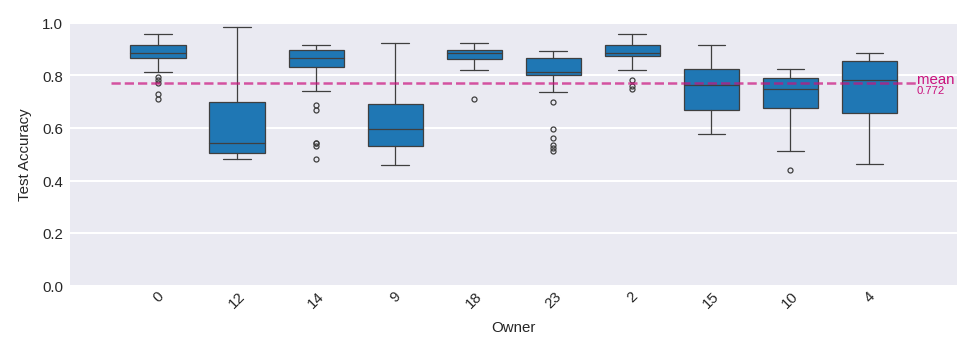

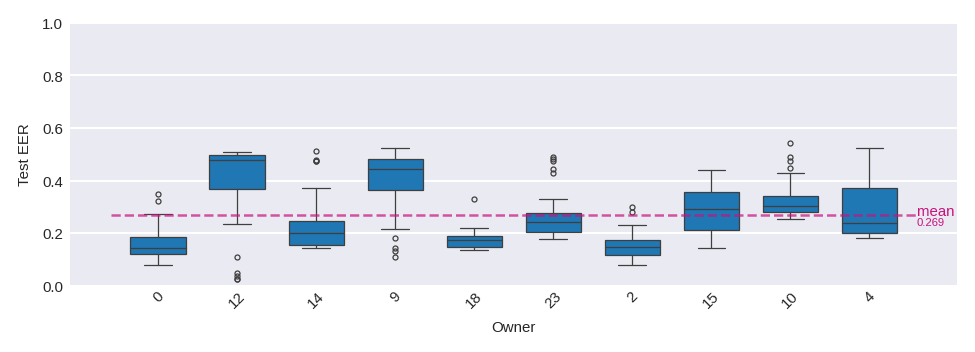

owner: 8 train_idx range: 0, 82
owner: 8 valid_idx range: 83, 165
imposter: 0 valid_idx range: 166, 248
imposter: 1 valid_idx range: 249, 331
imposter: 2 valid_idx range: 332, 414
imposter: 3 valid_idx range: 415, 497
imposter: 4 valid_idx range: 498, 580
imposter: 5 valid_idx range: 581, 663
imposter: 6 valid_idx range: 664, 746
imposter: 7 valid_idx range: 747, 829
imposter: 9 valid_idx range: 830, 912
   fit_time  score_time  test_eer  ...  test_recall  train_recall  owner
0  0.100654    0.029534  0.337079  ...     0.638554      0.915663     10
1  0.099944    0.028930  0.348837  ...     0.638554      0.915663     10
2  0.098777    0.028886  0.411111  ...     0.638554      0.915663     10
3  0.099078    0.028995  0.288462  ...     0.638554      0.915663     10
4  0.098919    0.028823  0.288462  ...     0.638554      0.915663     10
5  0.098792    0.028777  0.344828  ...     0.638554      0.915663     10
6  0.098577    0.028442  0.361446  ...     0.638554      0.915663     10
7  0.099

In [114]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
IFfig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

Overall mean: 0.7645
Overall mean: 0.2780


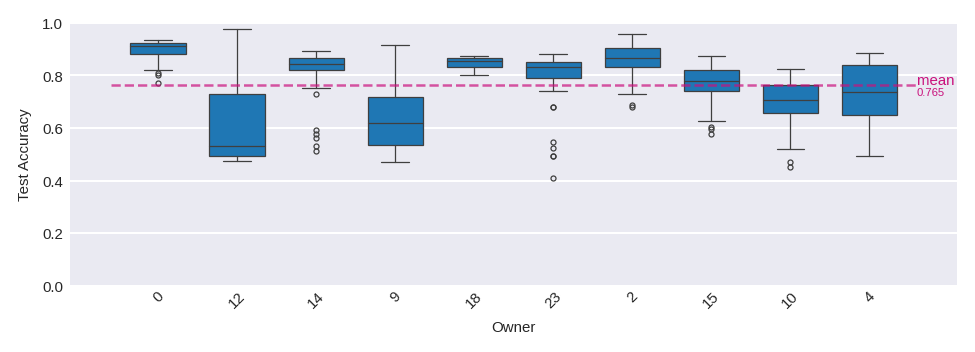

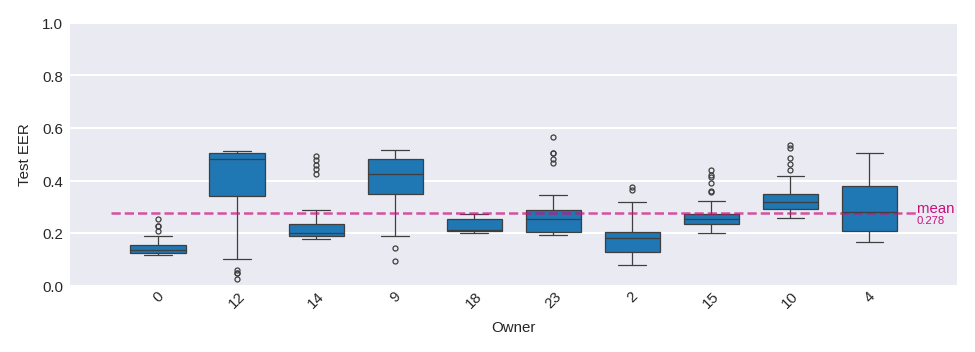

In [100]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
IFfig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

Overall mean: 0.7363
Overall mean: 0.2943


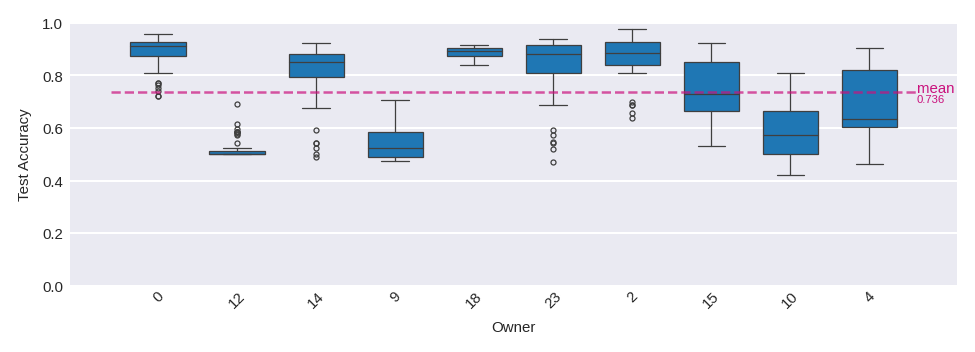

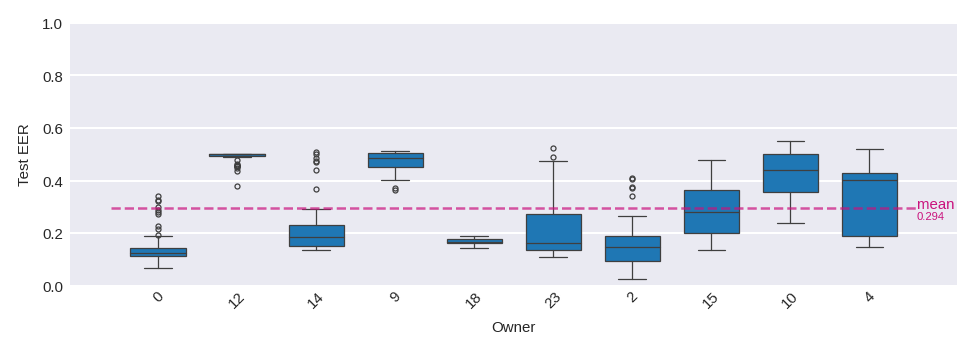

In [84]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
IFfig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

Overall mean: 0.7663
Overall mean: 0.2832


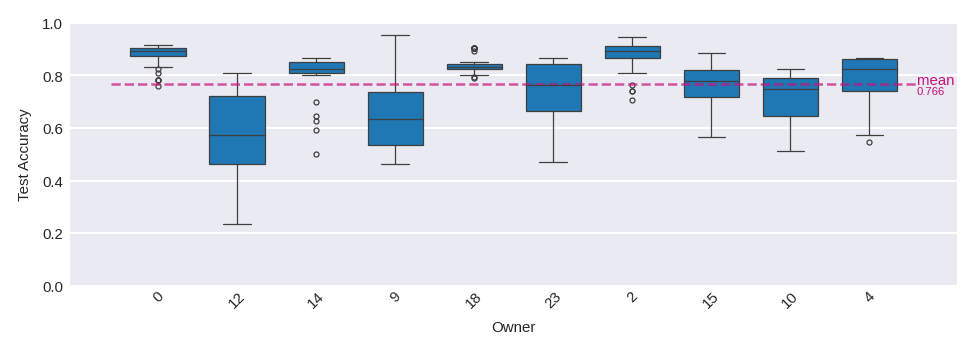

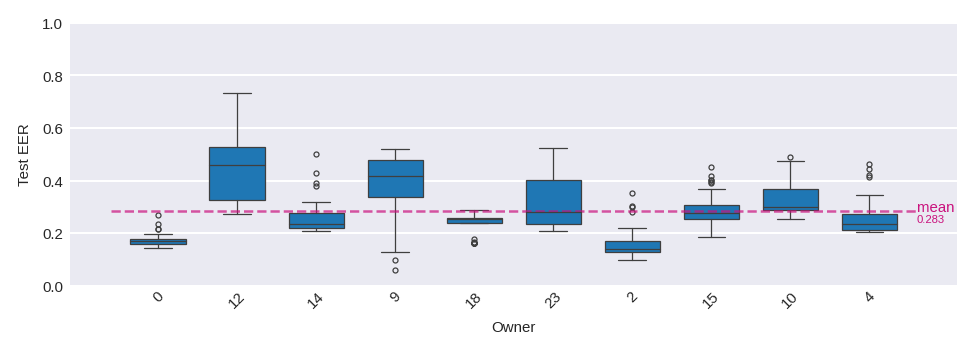

In [55]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
IFfig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")

Overall mean: 0.7699
Overall mean: 0.2794


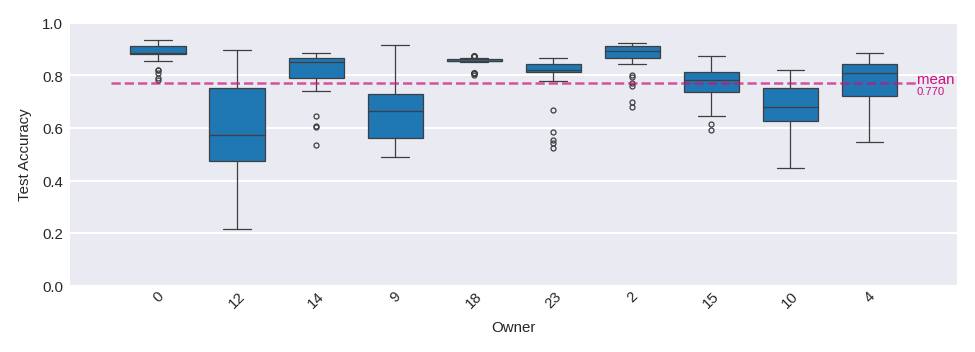

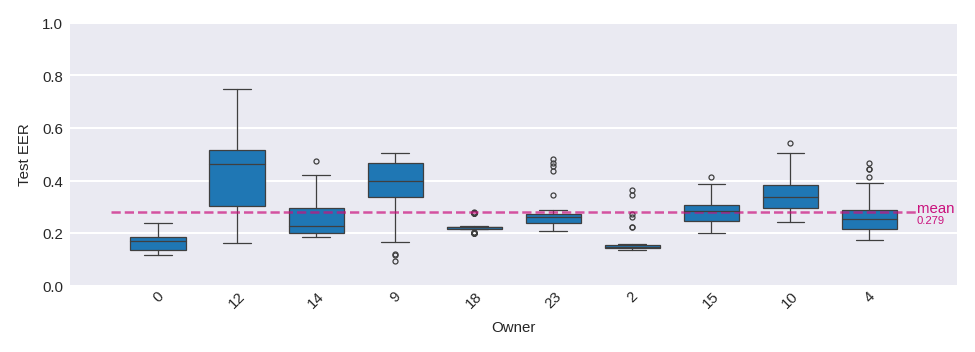

In [40]:
# test_df_plot[test_df_plot["Owner"]=="9"]
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
IFfig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")


Overall mean: 0.7608


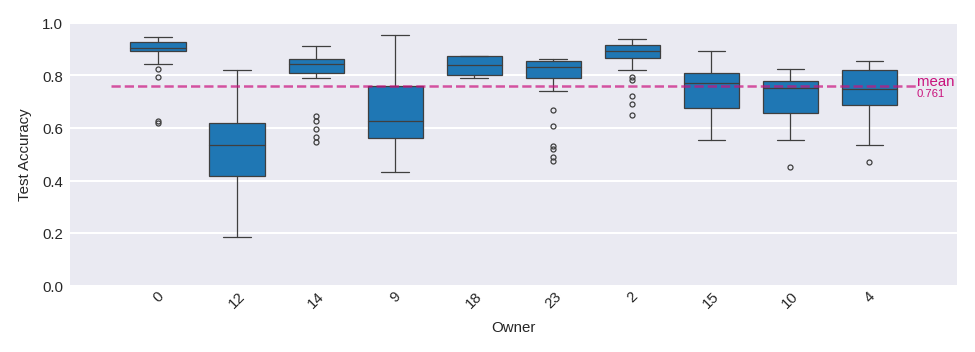

In [53]:
fig = utils_plot_acc_eer_dist(test_df_plot, "Test Accuracy")
plt.savefig(f'WACA-IF-Accuray-win_size={P.window_size}-step_width={P.IF_step_width}.png', bbox_inches='tight')

Overall mean: 0.2846


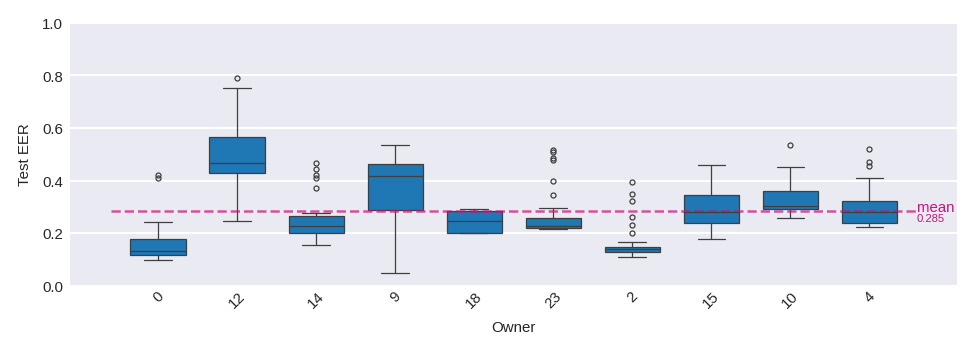

In [54]:
IFfig = utils_plot_acc_eer_dist(test_df_plot, "Test EER")
plt.savefig(f'WACA-IF-EER-win_size={P.window_size}-step_width={P.IF_step_width}.png', bbox_inches='tight')

In [89]:
utils_ppp(P)

,Value
name,VALID-ROBUST-IF
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


owner: 2 train_idx range: 0, 82
owner: 2 valid_idx range: 83, 165
imposter: 0 valid_idx range: 166, 248
imposter: 1 valid_idx range: 249, 331
imposter: 3 valid_idx range: 332, 414
imposter: 4 valid_idx range: 415, 497
imposter: 5 valid_idx range: 498, 580
imposter: 6 valid_idx range: 581, 663
imposter: 7 valid_idx range: 664, 746
imposter: 8 valid_idx range: 747, 829
imposter: 9 valid_idx range: 830, 912
   fit_time  score_time  test_eer  ...  test_recall  train_recall  owner
0  0.117446    0.029487  0.252525  ...     0.698795      0.891566     14
1  0.102563    0.029366  0.238095  ...     0.698795      0.891566     14
2  0.100275    0.029358  0.231481  ...     0.698795      0.891566     14
3  0.099910    0.028982  0.231481  ...     0.698795      0.891566     14
4  0.099543    0.028715  0.425743  ...     0.698795      0.891566     14
5  0.099458    0.028923  0.240385  ...     0.698795      0.891566     14
6  0.099875    0.029133  0.240385  ...     0.698795      0.891566     14
7  0.104

In [ ]:
IF_test_train_WACA_features_dic[0].shape

In [51]:
utils_ppp(P)

,Value
name,VALID-ROBUST-OCSVM
frequency,100
max_subjects,29
max_test_subjects,10
user_ids,"[1, 2, 3, 4, 5, 6, 7, 8, 19, 21, 22, 26, 27, 2..."
num_sample_points_per_exp,21000
exp_begin_cutoff_idx,500
exp_end_cutoff_idx,-500
seconds_per_subject_train,210
seconds_per_subject_test,210


In [ ]:
data = []
total = None
for k in tqdm(test_pca_results):
    total = list(test_pca_results[k]["total"].values())
    data.append([k] + total)
    
# Create the pandas DataFrame
columns = ["pca_n_components"] + list(test_pca_results[k]["total"].keys())
df = pd.DataFrame(data, columns = columns)
df

In [ ]:
fig, ax =plt.subplots(1,1, figsize=(8,8))

ax.set_title('different pca_n_component values on test_set')
g = sns.lineplot(x=df.pca_n_components, y=df.FAR, label = 'FAR', ax = ax)
g = sns.lineplot(x=df.pca_n_components, y=df.FRR, label = 'FRR', ax = ax)
g = sns.lineplot(x=df.pca_n_components, y=df.train_err_rate, label = 'train_err_rate', ax = ax)




# g.set_xticks(y_ticks)
ax.set_xlabel('n_components')


fig.show()

In [ ]:
# df_results[0]

In [ ]:
data = []
total = None
for k in tqdm(train_pca_results):
    total = list(train_pca_results[k]["total"].values())
    data.append([k] + total)
    
# Create the pandas DataFrame
columns = ["pca_n_components"] + list(train_pca_results[k]["total"].keys())
df = pd.DataFrame(data, columns = columns)
df

In [ ]:
fig, ax =plt.subplots(1,1, figsize=(8,8))

ax.set_title('different pca_n_component values on train_set')
g = sns.lineplot(x=df.pca_n_components, y=df.FAR, label = 'FAR', ax = ax)
g = sns.lineplot(x=df.pca_n_components, y=df.FRR, label = 'FRR', ax = ax)
g = sns.lineplot(x=df.pca_n_components, y=df.train_err_rate, label = 'train_err_rate', ax = ax)




# g.set_xticks(y_ticks)
ax.set_xlabel('n_components')


fig.show()